## Exploring Quantum process tomography for single qubit quantum channel

#### A single qubit channel map $\Phi(\rho)$ can be parametrized using 6 degrees of freedom without loss of much physical process generality (if the map is an ellipsoid in Bloch space, then we just its lose relative orientation) using a qubit dynamical map $D_{abcd}= \Phi(\rho)^{R}=\Phi(\rho)_{acbd}$ with lexicographical ordering where $a,b,c,d \in \{0,1\}$
$$D(\vec{\eta}, \vec{\kappa})=\begin{pmatrix} 1+\eta_z + \kappa_{z} & 0 & \kappa_{x}+i \kappa_y & \eta_x + \eta_y \\ 0 & 1-\eta_z + \kappa_{z} & \eta_{x} - \eta_y & \kappa_x + i\kappa_y \\ \kappa_x - i\kappa_y & \eta_{x} - \eta_y & 1-\eta_z + \kappa_{z} & 0 \\ \eta_x + \eta_y &  \kappa_x - i\kappa_y & 0 & 1+\eta_z + \kappa_{z} \\ \end{pmatrix}$$


This map is CPTP and hermitian and gives us a CPTP $\Phi(\rho)$ easily. It needs to satisfy both of the below 2 inequalities to be a meaningful physical process, namely:

$$(1 \pm \eta_i)^2 \geq (\eta_j \pm \eta_k)^2 $$

And it also has to satisfy these to physically conserve probability:

$$|\kappa_i| + |\eta_i| \leq 1 ~~~~~ \forall i$$

where $i,j,k$ are unique labels of the components of the 3-D $\vec{\eta}, \vec{\kappa}$


In [4]:
import numpy as np
import matplotlib
import scipy as sp
%matplotlib notebook
import matplotlib.pyplot as plt
from itertools import combinations

In [5]:
def qubit_dynamical_map(com_vec, shape_vec, tol=1e-5):
    """
    CPTP map phi_{abcd} in lexicographical indexing but with b and c swapped. 
    This actually obeys analogous physical constraints for the density matrix. 
    Taken from Zykzowski's geometry of quantum states. I am ignoring 6 further 
    degrees of freedom that specify orientation of ellipsoid axes and the bloch sphere 
    of input qubit when considering a map. Only considering shapeand center of 
    mass of the ellipsoid map in Bloch space.
    """
    
    k = com_vec      # affine parameter
    eta = shape_vec   # rotation vector
    
    satisfied = False
    i = 0
    # needs to satisfy any of the fujiwara-algoet conditions for complete posivitity
    for c in combinations(range(len(eta)), 2):      
                                                    # for any permutation c
        lhs1 = (1+eta[i])*(1+eta[i])
        rhs1 = (eta[c[0]]+eta[c[1]])*(eta[c[0]]+eta[c[1]])
        lhs2 = (1-eta[i])*(1-eta[i])
        rhs2 = (eta[c[0]]-eta[c[1]])*(eta[c[0]]-eta[c[1]])
        
        if lhs1 >= rhs1 and lhs2 >= rhs2:
            satisfied = True
            break
        i+=1
        
    if satisfied == False:
        return "Fujiwara-Algoet necessary conditions are not satisfied. Not CPTP"
        
    for i in range(len(eta)): # affine condition
        if abs(k[i])+ abs(eta[i]) - 1 > tol:
            return "Not CPTP. Affine+Rotation don't preserve trace"
        
        
    D = 0.5*np.array([[1+eta[2]+k[2], 0, k[0]+1j*k[1], eta[0]+eta[1]], [0, 1-eta[2]+k[2], eta[0]-eta[1], k[0]+1j*k[1]],
                        [k[0]-1j*k[1], eta[0]-eta[1], 1-eta[2]-k[2], 0], [eta[0]+eta[1], k[0]-1j*k[1], 0, 1+eta[2]-k[2]]])

    return D.reshape((4,4))

In [6]:
from itertools import combinations
for i in combinations(range(3),2):
    print(i)

(0, 1)
(0, 2)
(1, 2)


In [7]:

rotation_map = qubit_dynamical_map([0,0,0], [1,1,1])
rotation_map

array([[1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [8]:
2*1/np.linalg.norm([1,1,1])

1.1547005383792517

In [9]:
rotation_map = qubit_dynamical_map([0,0,0], [1,1,1])

def herm(cmap):
    return np.allclose(np.conjugate(cmap.transpose()), cmap)

herm(rotation_map)   # is a simple dynamical map for a rotation matrix hermitian?

True

In [10]:
def pt(cmap, sub='a'):
    rcmap = cmap.reshape((2,2,2,2)) # reshape in tensor form
    if sub == 'a':
        return np.einsum('ijik->jk', rcmap)
    if sub == 'b':
        return np.einsum('ijkj->ik', rcmap)

print(pt(rotation_map))    
np.allclose(pt(rotation_map), np.eye(2)) # is the partial trace an identity?

[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


True

### Therefore, we have checked that a simple rotation matrix is CPTP. It is unital in that the COM of the ellipsoid is fixed so $\vec{\kappa}=\vec{0}$ and it leaves the identity invariant that we can see by the following application:

In [11]:
def rho(bloch_vec):
    eta = bloch_vec
    rho = 0.5*np.array([[1+eta[2], eta[0]-1j*eta[1]], [eta[0]+1j*eta[1], 1-eta[2]]]).reshape((2,2))
    return rho
rho([0,0,0])

vrho = np.vectorize(rho, signature='(n,1)->(m,m)') # vectorized for multiple bloch vectors
vrho(np.array([[1,0,0], [1, 0, 0]]).reshape(2,3,1))

array([[[0.5+0.j, 0.5+0.j],
        [0.5+0.j, 0.5+0.j]],

       [[0.5+0.j, 0.5+0.j],
        [0.5+0.j, 0.5+0.j]]])

In [12]:
rotation_map

array([[1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [13]:
def qmap(dmap):   # return a single qubit map here by applying the reverse swap
    return np.transpose(dmap.reshape((2,2,2,2)), axes=(0, 2, 1, 3)).reshape((4,4))


In [14]:
phi = qmap(rotation_map)
phi

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

Notice that this is just the identity map.

In [15]:
rho_p = np.matmul(phi, np.array([1,0,0,0]).transpose())  
# apply it on the identity (remember that the first 1 is for the affine parameter)

rho_p

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [16]:
rho(rho_p[1:])

array([[0.5+0.j, 0. +0.j],
       [0. +0.j, 0.5+0.j]])

Hence the identity has been left invariant as a result of this qubit operation. We call these operations unital:

$$\Phi(\mathbb{1})=\mathbb{1}$$


### Now that we have some tests to ensure that whatever map we generate is CPTP, let's move on to coherent state preparation to start the tomographic procedure.

Let us parametrize a pure state using two degrees of freedom using the popular spherical coordinate representation of the state-vector $$|\psi> = \cos {\theta/2} + e^{-i\frac{\phi}{2}}\sin{\theta/2}$$ 

where $0 \leq \theta \leq \pi$ and $0 \leq \phi \leq 2\pi$ which translates to the bloch vector $\vec{\eta}$ of the pure density matrix $$\rho = |\psi><\psi| = \frac{1}{2}\left(\mathbb{1} + \vec{\eta} . \vec{\sigma} \right)$$ as 

$$\vec{\eta} = (\sin{\theta}\cos{\phi}, \sin{\theta}\sin{\phi}, \cos{\theta}) $$ where $\vec{\sigma}$ is the usual pauli vector. Note crucially that $\vec{\eta}.\vec{\eta}=1$ and this is just the usual parametrization of the 2-sphere aka the Bloch sphere.

We need to now create an ensemble of prepared states of the form with a predetermined bloch vector $(1,\vec{\eta})^T$,



In [17]:
def eta(theta, phi):
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

print([rho(eta(i,i*2)) for i in np.linspace(0, np.pi, 10)])
print([rho(eta(i,i*2)).trace() for i in np.linspace(0, np.pi, 10)]) # trace is 1
print([np.sum(eta(i,i*2)*eta(i,i*2))                                # mod squared is 1
       for i in np.linspace(0, np.pi, 10)])

np.shape(rotation_map)

[array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]]), array([[0.96984631+0.j        , 0.13100132-0.10992316j],
       [0.13100132+0.10992316j, 0.03015369+0.j        ]]), array([[0.88302222+0.j        , 0.05580945-0.31651111j],
       [0.05580945+0.31651111j, 0.11697778+0.j        ]]), array([[ 0.75      +0.j   , -0.21650635-0.375j],
       [-0.21650635+0.375j,  0.25      +0.j   ]]), array([[ 0.58682409+0.j        , -0.46270829-0.16841204j],
       [-0.46270829+0.16841204j,  0.41317591+0.j        ]]), array([[ 0.41317591+0.j        , -0.46270829+0.16841204j],
       [-0.46270829-0.16841204j,  0.58682409+0.j        ]]), array([[ 0.25      +0.j   , -0.21650635+0.375j],
       [-0.21650635-0.375j,  0.75      +0.j   ]]), array([[0.11697778+0.j        , 0.05580945+0.31651111j],
       [0.05580945-0.31651111j, 0.88302222+0.j        ]]), array([[0.03015369+0.j        , 0.13100132+0.10992316j],
       [0.13100132-0.10992316j, 0.96984631+0.j        ]]), array([[0.000000e+00+0.00000000e+00j, 6.123

(4, 4)

The trace of density matrices is 1 and the bloch vector is normalized as expected from the parametrization. Let us also create functions for creating ensembles (copies) of the input state/s, qubit map/s and measurement operator/s:

In [18]:
def sensembler(number, obj):
    "generates an ensemble: a specified number of copies of states or measurement operator parametrized by the bloch vector or single qubit map"
    if obj.shape == (3,):
        return np.array([[1, obj[0], obj[1], obj[2]] for _ in range(number)]).reshape(number,4,1)
    if obj.shape == (4,4):
        return np.array([obj for _ in range(number)])
    if obj.shape == (2,2):
        return np.array([obj for _ in range(number)])
    else:
        return np.array([obj for _ in range(number)])
    
    
def ensembler(numbers, objs):
    "both number and objs are n-dim arrays. Just vectorizing above."
    for i, obj in enumerate(objs):
        if i == 0:
            vensemble = sensembler(numbers[i], obj)
        else:
            vensemble = np.concatenate((vensemble, sensembler(numbers[i], obj) ), axis=0)
    return vensemble


ensembler([50 for _ in range(1000)], [eta(i,0.25*np.pi) for i in np.linspace(0,np.pi,1000)]).shape


(50000, 4, 1)

In [19]:
p = np.matmul(sensembler(10, rotation_map), sensembler(10, eta(0,0)))[:,1:]
vrho(p)  # vectorized rho in action!

array([[[ 1.5+0.j,  0. +0.j],
        [ 0. +0.j, -0.5+0.j]],

       [[ 1.5+0.j,  0. +0.j],
        [ 0. +0.j, -0.5+0.j]],

       [[ 1.5+0.j,  0. +0.j],
        [ 0. +0.j, -0.5+0.j]],

       [[ 1.5+0.j,  0. +0.j],
        [ 0. +0.j, -0.5+0.j]],

       [[ 1.5+0.j,  0. +0.j],
        [ 0. +0.j, -0.5+0.j]],

       [[ 1.5+0.j,  0. +0.j],
        [ 0. +0.j, -0.5+0.j]],

       [[ 1.5+0.j,  0. +0.j],
        [ 0. +0.j, -0.5+0.j]],

       [[ 1.5+0.j,  0. +0.j],
        [ 0. +0.j, -0.5+0.j]],

       [[ 1.5+0.j,  0. +0.j],
        [ 0. +0.j, -0.5+0.j]],

       [[ 1.5+0.j,  0. +0.j],
        [ 0. +0.j, -0.5+0.j]]])

Let us also parametrize the measurement basis using the same methodology as axes of the bloch sphere. This is a degree of freedom we will explore after seeing how preparation variation affects process estimation fidelity.

In [20]:
p = 0.5 # phase flip channel
channel = qmap(qubit_dynamical_map([0,0,0], [1-p, 1-p, 1]))

channel_v2 = [0,0,0,1-p,1-p,1]

cs = sensembler(9,np.array(channel_v2).reshape(6,1))

In [21]:
def povm(eta):
    "generating measurement operators that are not necessarily orthogonal but always positive hence povm"
    m = eta[0]*np.array([[0, 1], [1, 0]]).reshape((2,2)) + eta[1]*np.array([[0, -1j], [1j, 0]]).reshape((2,2)) \
    + eta[2]*np.array([[1, 0], [0, -1]]).reshape((2,2))
    return m


X = povm([1,0,0])
Y = povm([0,1,0])
Z = povm([0,0,1])

states = ensembler([3, 3, 3], [np.array([1,0,0]), np.array([0,1,0]), np.array([0,0,1])])
rmap = sensembler(9, channel) 
mops = ensembler([1 for _ in range(9)], [X, Y, Z, X, Y, Z, X, Y, Z])
transformed_states = vrho(np.matmul(rmap, states)[:,1:]) # ignoring the affine parameter in the 4-vector and generating rho
measurements = np.trace(np.matmul(mops, transformed_states), axis1=1, axis2=2)

measurements

tstates = vrho(cs[:,3:]*states[:,1:] + cs[:,:3])   # just an affine transformation of the states!

measurements2 = np.trace(np.matmul(mops, tstates), axis1=1, axis2=2)
print(measurements2)
measurements


[0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j 0. +0.j 0. +0.j 0. +0.j 1. +0.j]


array([0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0.5+0.j, 0. +0.j, 0. +0.j,
       0. +0.j, 1. +0.j])

In [22]:
cs[:,3:]*states[:,1:] + cs[:,:3]

array([[[0.5],
        [0. ],
        [0. ]],

       [[0.5],
        [0. ],
        [0. ]],

       [[0.5],
        [0. ],
        [0. ]],

       [[0. ],
        [0.5],
        [0. ]],

       [[0. ],
        [0.5],
        [0. ]],

       [[0. ],
        [0.5],
        [0. ]],

       [[0. ],
        [0. ],
        [1. ]],

       [[0. ],
        [0. ],
        [1. ]],

       [[0. ],
        [0. ],
        [1. ]]])

In [23]:
ps = 0.5*(measurements+1) # constructing a sampling binomial vector for random measurements for Pauli X, Y, Z or any op
# np.random.choice(2,100, p=[ps, one_ps])
ps

array([0.75+0.j, 0.5 +0.j, 0.5 +0.j, 0.5 +0.j, 0.75+0.j, 0.5 +0.j,
       0.5 +0.j, 0.5 +0.j, 1.  +0.j])

In [24]:
ps

array([0.75+0.j, 0.5 +0.j, 0.5 +0.j, 0.5 +0.j, 0.75+0.j, 0.5 +0.j,
       0.5 +0.j, 0.5 +0.j, 1.  +0.j])

In [29]:
# a plot to show convergence of randomness inserted into measurements for measuring 3 arbitrary states

res = 50
clicks = np.linspace(10,10000, res)
expecs = np.zeros(9*len(clicks)).reshape(res, 9)
vexpecs = np.zeros(9*len(clicks)).reshape(res, 9)

for i, click in enumerate(clicks):

    click = int(click)
    probs = np.stack((ps, (1-ps)), axis=1)
    p = ensembler([click for _ in range(9)], probs)

    c = p.cumsum(axis=1)   # cumulative distribution
    u = np.random.rand(len(c), 1)  # use random numbers instead of np.random.choice to vectorize the problem
    outcomes = (u < c).argmax(axis=1)*-2+1  # displace appropriately for sigma x and other expectation values
    for j in range(9): 
        expecs[i][j] = outcomes[j*click:(j+1)*click].mean()
        varsqr = outcomes[j*click:(j+1)*click].std()
        vexpecs[i][j] = varsqr  # not necessary! outcomes are bernoulli


<IPython.core.display.Javascript object>


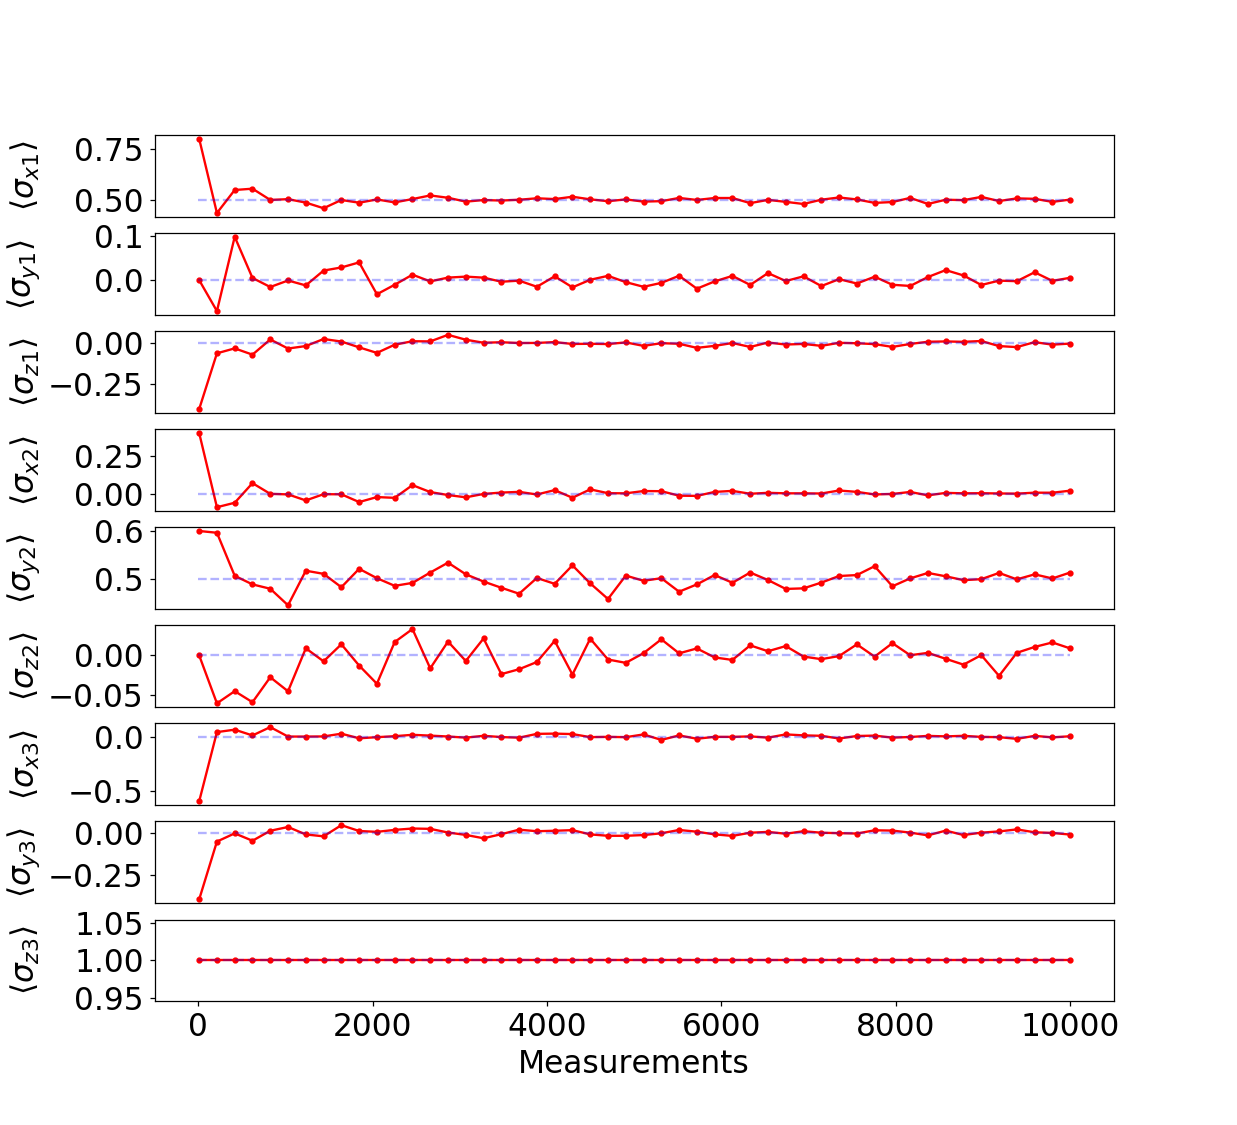

C:\Users\mirta\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [37]:
fig, ax = plt.subplots(nrows=9, figsize=(11,10))
labels = [r'$\langle \sigma_{x1} \rangle$', r'$\langle \sigma_{y1} \rangle$', r'$\langle \sigma_{z1} \rangle$', 
          r'$\langle \sigma_{x2} \rangle$', r'$\langle \sigma_{y2} \rangle$', r'$\langle \sigma_{z2} \rangle$'
         , r'$\langle \sigma_{x3} \rangle$', r'$\langle \sigma_{y3} \rangle$', r'$\langle \sigma_{z3} \rangle$']
for i in range(9):
    ax[i].plot(clicks, expecs[:,i], 'r.-')
    ax[i].plot(np.linspace(0, 10000, 1000), measurements[i]*np.ones(1000), 'b--', alpha=0.3 )
    ax[i].set_ylabel(labels[i], fontsize=20)
    if i != 8:
        ax[i].get_xaxis().set_ticks([])
    ax[i].tick_params(axis='both', which='major', labelsize=20)

    
plt.xlabel('Measurements', fontsize=20)
fig.align_ylabels()
plt.savefig("qstconvergence.pdf", dpi=1000, bbox_inches='tight')

There is convergence to the true expectation values as seen from the plot above for the three bloch-orthogonally prepared states after doing random X, Y, Z measurements in Pauli basis for ensemles of sizes denoted by "clicks" or measurements. I have used a vectorized sampling method here that significantly speeds up the experimentalist measurement process. (by a factor of a 1000! (not factorial!)). Notice that state 3 after transformation is still an eigenstate of sigma z and its measurement outcome is always unchanged.

## Starting here, I combine all the tools built so far to try single qubit channel estimation using different metrics:

I use two learning methods:

1. l1-norm estimation using linear inversion. This requires no functional minimization.

2. Minimizing an objective maximum likelihood method

I use the l1-norm and entanglement fidelity *see fuunction definitions* as metrics to judge performance. I also show that both schemes converge almost surely and that the maximum likelihood scheme is more unstable.

In [28]:
def ee(x): 
    "estimated function for the channel. Optimizer friendly qubit channel cost function to maximalize likelihood functional."
    k = [x[0], x[1], x[2]]      # affine parameter
    eta = [x[3], x[4], x[5]]  # rotation vector
    D = 0.5*np.array([[1+eta[2]+k[2], 0, k[0]+1j*k[1], eta[0]+eta[1]], [0, 1-eta[2]+k[2], eta[0]-eta[1], k[0]+1j*k[1]],
                        [k[0]-1j*k[1], eta[0]-eta[1], 1-eta[2]-k[2], 0], [eta[0]+eta[1], k[0]-1j*k[1], 0, 1+eta[2]-k[2]]])

    return qmap(D.reshape((4,4)))

# take a test channel and evaluate the protocol
cpars = [0,0,0,0.5, 0.5, 1]
channel = qmap(qubit_dynamical_map(cpars[:3], cpars[3:]))
channel


array([[1. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0.5+0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0.5+0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, 1. +0.j]])

In [61]:
X = povm([1,0,0])
Y = povm([0,1,0])
Z = povm([0,0,1])  # starting with paulis

p = 0.1 # phase flip channel

#cpars = [0,0,p, np.sqrt(1-p), np.sqrt(1-p), 1-p]

def qexperiment(click):
    state_params = [np.array([1,0,0]),np.array([-1,0,0]), np.array([0,1,0]),np.array([0,-1,0]), 
                                   np.array([0,0,-1]),np.array([0,0,1])]

    states = np.array([[1,0,0], [-1,0,0], [0,1,0], [0,-1,0], [0,0,-1], [0,0,+1]])
    states = ensembler([3,3,3,3,3,3], states)[:,1:]

    cpars=[0,0,0,0.5,0.5,1]
    cs = sensembler(len(3*state_params),np.array(cpars).reshape((6,1)))
    transformed_states = vrho(cs[:,3:]*states + cs[:,:3])
    mops = np.array([X,Y,Z]*int(len(states)/3)) # pauli xyz for each eigenstate of xyz
    measurements = np.trace(np.matmul(mops, transformed_states), axis1=1, axis2=2)
    ps = 0.5*(measurements+1)

    click = click # number of physical measurements or detector clicks
    probs = np.stack((ps, (1-ps)), axis=1)
    p = ensembler([click for _ in range(3*len(state_params))], probs)

    c = p.cumsum(axis=1)   # cumulative distribution
    u = np.random.rand(len(c), 1)  # use random numbers instead of np.random.choice to vectorize the choosing problem
    outcomes = (u < c).argmax(axis=1)*-2+1  # displace appropriately for sigma x and other expectation values. (
                                            # rounds to zero if positive measured and rounds to 1 if negative meeasured so scale
                                            # the outcomes appropriately
    
    return outcomes


def eigbasis(operators, eigval_verbose=False):
    
    eigvals, eigbasis = np.linalg.eig(operators)
    
    if eigval_verbose == False:
        return np.matmul(eigbasis.reshape(len(operators),2,2,1), np.conjugate(eigbasis.reshape(len(operators),2,1,2)))
    else:
        return np.matmul(eigbasis.reshape(len(operators),2,2,1), np.conjugate(eigbasis.reshape(len(operators),2,1,2))), eigvals
    
def outcomes_to_povm(outcomes, click, operators):
    "maps measurement outcomes to projectors"
    eigenbasis = eigbasis(operators)
    outcome_projectors = np.zeros(4*len(outcomes), dtype='complex64').reshape((len(outcomes),2,2))
    for j in range(len(operators)):
        oo = outcomes[j*click:(j+1)*click] # operator outcomes
        for i, outcome in enumerate(oo):
            if outcome == 1:
                outcome_projectors[j*click+i] = eigenbasis[j][0]
            else:
                outcome_projectors[j*click+i] = eigenbasis[j][1]
    return outcome_projectors


eigbasis([X,Y,Z])


#(cs[:,3:]*states[:,1:] + cs[:,:3])


#(cs[:,3:]*states[:,1:] + cs[:,:3])

array([[[[ 0.5+0.j ,  0.5+0.j ],
         [ 0.5+0.j ,  0.5+0.j ]],

        [[ 0.5+0.j , -0.5+0.j ],
         [-0.5+0.j ,  0.5+0.j ]]],


       [[[ 0.5+0.j ,  0. -0.5j],
         [ 0. +0.5j,  0.5+0.j ]],

        [[ 0.5+0.j ,  0. +0.5j],
         [ 0. -0.5j,  0.5+0.j ]]],


       [[[ 1. +0.j ,  0. +0.j ],
         [ 0. +0.j ,  0. +0.j ]],

        [[ 0. +0.j ,  0. +0.j ],
         [ 0. +0.j ,  1. +0.j ]]]])

### l1-norm estimation of expected $\hat{\vec{\eta}},\hat{\vec{\kappa}}$  and true vector $\vec{\eta},\vec{\kappa}$

In [40]:
init_states = np.array([[1,0,0], [-1,0,0], [0,1,0], [0,-1,0], [0,0,-1], [0,0,+1]])
init_states = init_states.reshape((len(init_states)), 3, 1)
true_map = sensembler(len(init_states), np.array(cpars).reshape(6,1))  # vectorize the ensemble
tau_primes_true = init_states*true_map[:,3:] + true_map[:,:3]
tau_primes_true

outcomes = qexperiment(click=1000)

In [42]:
reconstructed_sigmas = np.mean(outcomes.reshape((len(init_states)*3), int(len(outcomes)/(3*len(init_states)))), axis=1)
tau_primes_estimated = reconstructed_sigmas.reshape(int((len(reconstructed_sigmas))/3), 3, 1)
tau_primes_estimated  # good sign, there is convergence in the estimation step for large ensemble sizes

array([[[ 0.514],
        [-0.044],
        [-0.038]],

       [[-0.526],
        [-0.002],
        [ 0.014]],

       [[ 0.038],
        [ 0.494],
        [ 0.012]],

       [[-0.05 ],
        [-0.486],
        [-0.012]],

       [[-0.064],
        [-0.012],
        [-1.   ]],

       [[-0.052],
        [-0.072],
        [ 1.   ]]])

In [43]:
outcomes.reshape((len(init_states)*3), int(len(outcomes)/(3*len(init_states))))

array([[-1, -1,  1, ...,  1,  1,  1],
       [ 1, -1, -1, ...,  1, -1,  1],
       [-1, -1,  1, ...,  1,  1, -1],
       ...,
       [ 1, -1,  1, ...,  1,  1,  1],
       [-1,  1,  1, ..., -1, -1,  1],
       [ 1,  1,  1, ...,  1,  1,  1]], dtype=int64)

In [44]:
l1_norm = tau_primes_true - tau_primes_estimated
cost = np.sum(np.sum(np.abs(l1_norm), axis=1))
cost

0.47000000000000003

In [45]:
np.sum(np.abs(l1_norm))

0.47000000000000003

In [46]:
def f2_rev(x, outcomes, states):
    init_states = np.array(states)
    init_states = init_states.reshape((len(init_states)), 3, 1)
    estimated_map = sensembler(len(init_states), np.array(x).reshape(6,1))  # vectorize the ensemble
    tau_primes_true = init_states*estimated_map[:,3:] + estimated_map[:,:3]   # how vector transforms
    reconstructed_sigmas = np.mean(outcomes.reshape((len(init_states)*3), int(len(outcomes)/(3*len(init_states)))), axis=1)
    # for x y z
    tau_primes_estimated = reconstructed_sigmas.reshape(int((len(reconstructed_sigmas))/3), 3, 1)
    l1_norm = tau_primes_true - tau_primes_estimated
    #diffs = np.sum(l1_norm, axis=1)
    #l2_norm = diffs*diffs
    cost = np.sum(np.abs(l1_norm))
    #cost = np.sum(l2_norm)
    return cost 
        # minimizing the l1 norm distance between measured states and what we think how the channel transforms the states
    
states = init_states

In [47]:
f2_rev(cpars, outcomes, init_states)

0.47000000000000003

In [74]:
import scipy
import scipy as sp

In [75]:
from scipy import optimize
from qutip import *

In [76]:
opt = sp.optimize.minimize(f2_rev, [0.5,0.5,0.5,0.5,0.5,0.5],args=(outcomes, init_states), method='trust-constr',
                           constraints=(con1, con2, con3, con4, con5, con6), options={'verbose':3,}) 

opt.x

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   7   |   0   | +8.8980e+00 | 1.00e+00 | 2.20e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  14   |   1   | +1.8706e+00 | 7.00e+00 | 1.70e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  21   |   4   | +1.8706e+00 | 7.00e-01 | 1.70e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   4   |  28   |   6   | +1.8706e+00 | 2.51e-01 | 1.70e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   5   |  35   |   8   | +1.8706e+00 | 5.39e-02 | 1.70e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   6   |  42   |   9   | +1.8706e+00 | 2.69e-02 | 1.70e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   7   |  49   |  10   | +1.8937e+00 | 2.69e-02 | 1.00e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   8   |  56   |  11   | +1.9131e+00 | 2.69e-

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


|  42   |  392  |  116  | +7.8199e-01 | 1.48e-02 | 5.65e-01 | 0.00e+00 | 2.29e+00 |  1.00e-01   |   2   |
|  43   |  399  |  118  | +7.6764e-01 | 1.04e-01 | 4.70e-01 | 0.00e+00 | 2.29e+00 |  1.00e-01   |   2   |
|  44   |  413  |  121  | +7.6764e-01 | 2.47e-02 | 4.70e-01 | 0.00e+00 | 2.29e+00 |  1.00e-01   |   2   |
|  45   |  427  |  123  | +7.6764e-01 | 1.24e-02 | 4.70e-01 | 0.00e+00 | 2.29e+00 |  1.00e-01   |   2   |
|  46   |  441  |  124  | +7.6764e-01 | 6.18e-03 | 4.70e-01 | 0.00e+00 | 2.29e+00 |  1.00e-01   |   2   |
|  47   |  448  |  125  | +7.6764e-01 | 3.09e-03 | 4.70e-01 | 0.00e+00 | 2.29e+00 |  1.00e-01   |   2   |
|  48   |  455  |  126  | +7.6717e-01 | 3.09e-03 | 5.35e-01 | 0.00e+00 | 2.29e+00 |  1.00e-01   |   2   |
|  49   |  462  |  127  | +7.6557e-01 | 3.09e-03 | 4.39e-01 | 0.00e+00 | 2.29e+00 |  1.00e-01   |   2   |
|  50   |  469  |  129  | +7.6575e-01 | 6.18e-03 | 5.68e-01 | 0.00e+00 | 2.29e+00 |  1.00e-01   |   2   |
|  51   |  483  |  132  | +7.6575e-01 | 3.09e-

|  142  | 1246  |  298  | +7.5347e-01 | 6.89e-03 | 4.61e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  143  | 1253  |  301  | +7.5230e-01 | 1.38e-02 | 1.39e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  144  | 1260  |  304  | +7.4954e-01 | 9.64e-02 | 4.93e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  145  | 1274  |  308  | +7.4954e-01 | 4.82e-02 | 4.93e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  146  | 1281  |  312  | +7.3330e-01 | 4.82e-02 | 3.77e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  147  | 1288  |  316  | +7.3257e-01 | 9.64e-02 | 3.16e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  148  | 1302  |  321  | +7.3257e-01 | 4.82e-02 | 3.16e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  149  | 1309  |  325  | +7.1443e-01 | 3.38e-01 | 1.38e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  150  | 1323  |  331  | +7.1443e-01 | 1.48e-01 | 1.38e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   1   |
|  151  | 1337  |  336  | +7.1443e-01 | 7.38e-

|  269  | 2303  |  681  | +4.9377e-01 | 3.93e-07 | 4.02e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  270  | 2310  |  683  | +4.9377e-01 | 3.93e-07 | 7.36e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  271  | 2317  |  685  | +4.9377e-01 | 3.93e-07 | 4.02e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  272  | 2324  |  686  | +4.9377e-01 | 3.93e-07 | 4.02e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  273  | 2331  |  687  | +4.9377e-01 | 1.96e-07 | 4.02e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  274  | 2338  |  688  | +4.9377e-01 | 1.37e-06 | 9.01e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  275  | 2345  |  690  | +4.9377e-01 | 4.38e-07 | 9.01e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  276  | 2352  |  692  | +4.9377e-01 | 2.19e-07 | 9.01e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  277  | 2359  |  693  | +4.9377e-01 | 1.09e-07 | 9.01e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  278  | 2366  |  694  | +4.9377e-01 | 5.47e-

|  368  | 3185  |  825  | +4.9343e-01 | 4.06e-05 | 5.05e-01 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  369  | 3192  |  828  | +4.9343e-01 | 2.03e-05 | 5.05e-01 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  370  | 3199  |  831  | +4.9343e-01 | 1.02e-05 | 5.05e-01 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  371  | 3206  |  834  | +4.9343e-01 | 5.08e-06 | 5.05e-01 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  372  | 3213  |  837  | +4.9343e-01 | 2.54e-06 | 5.05e-01 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  373  | 3220  |  839  | +4.9343e-01 | 2.54e-06 | 4.06e-02 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  374  | 3227  |  841  | +4.9343e-01 | 5.08e-06 | 4.06e-02 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  375  | 3234  |  843  | +4.9343e-01 | 2.54e-06 | 4.06e-02 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  376  | 3241  |  845  | +4.9343e-01 | 1.27e-06 | 4.06e-02 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  377  | 3248  |  847  | +4.9343e-01 | 2.54e-

|  478  | 4067  |  971  | +4.9332e-01 | 3.48e-03 | 3.79e-01 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |
|  479  | 4081  |  975  | +4.9332e-01 | 1.74e-03 | 3.79e-01 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |
|  480  | 4088  |  979  | +4.9309e-01 | 1.22e-02 | 4.09e-02 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |
|  481  | 4095  |  983  | +4.9249e-01 | 2.44e-02 | 5.57e-03 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |
|  482  | 4102  |  988  | +4.8961e-01 | 1.71e-01 | 4.01e-02 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |
|  483  | 4109  |  993  | +4.7129e-01 | 1.19e+00 | 4.37e-01 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |
|  484  | 4116  |  999  | +4.1795e-01 | 3.65e+00 | 1.65e-03 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   1   |
|  485  | 4123  | 1005  | +4.0611e-01 | 3.65e+00 | 2.24e-02 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   1   |
|  486  | 4130  | 1011  | +3.9933e-01 | 3.65e+00 | 1.06e-03 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   1   |
|  487  | 4137  | 1017  | +3.8920e-01 | 3.65e+

|  591  | 4956  | 1236  | +3.4646e-01 | 7.00e+00 | 1.35e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   2   |
|  592  | 4963  | 1242  | +3.4608e-01 | 7.00e+00 | 3.01e-01 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   1   |
|  593  | 4970  | 1244  | +3.4607e-01 | 7.00e+00 | 1.34e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   4   |
|  594  | 4977  | 1250  | +3.4607e-01 | 7.00e+00 | 1.34e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   1   |
|  595  | 4984  | 1256  | +3.4605e-01 | 7.00e+00 | 1.34e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   1   |
|  596  | 4991  | 1261  | +3.4605e-01 | 7.00e+00 | 1.34e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   4   |
|  597  | 4998  | 1266  | +3.4605e-01 | 7.00e+00 | 1.34e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   4   |
|  598  | 5005  | 1271  | +3.4605e-01 | 7.00e+00 | 1.34e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   4   |
|  599  | 5012  | 1276  | +3.4605e-01 | 7.00e+00 | 1.34e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   4   |
|  600  | 5019  | 1281  | +3.4605e-01 | 7.00e+

|  683  | 5691  | 1688  | +3.4605e-01 | 2.82e-05 | 1.34e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   2   |
|  684  | 5705  | 1693  | +3.4605e-01 | 2.82e-06 | 1.34e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   2   |
|  685  | 5712  | 1697  | +3.4605e-01 | 1.98e-05 | 1.34e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   2   |
|  686  | 5726  | 1702  | +3.4605e-01 | 1.98e-06 | 1.34e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   2   |
|  687  | 5733  | 1706  | +3.4605e-01 | 1.38e-05 | 1.34e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   2   |
|  688  | 5747  | 1710  | +3.4605e-01 | 1.38e-06 | 1.34e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   2   |
|  689  | 5754  | 1714  | +3.4605e-01 | 9.69e-06 | 1.34e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   2   |
|  690  | 5761  | 1718  | +3.4605e-01 | 6.78e-05 | 1.34e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   2   |
|  691  | 5775  | 1724  | +3.4605e-01 | 6.78e-06 | 1.34e-05 | 0.00e+00 | 1.00e+00 |  3.20e-05   |   2   |
|  692  | 5782  | 1728  | +3.4605e-01 | 4.75e-

|  774  | 6650  | 2097  | +3.4601e-01 | 4.38e-06 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  775  | 6664  | 2102  | +3.4601e-01 | 4.38e-07 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  776  | 6671  | 2106  | +3.4601e-01 | 3.07e-06 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  777  | 6685  | 2111  | +3.4601e-01 | 3.07e-07 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  778  | 6692  | 2115  | +3.4601e-01 | 2.15e-06 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  779  | 6706  | 2120  | +3.4601e-01 | 2.15e-07 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  780  | 6713  | 2124  | +3.4601e-01 | 1.50e-06 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  781  | 6720  | 2128  | +3.4601e-01 | 1.05e-05 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  782  | 6734  | 2133  | +3.4601e-01 | 1.05e-06 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   4   |
|  783  | 6741  | 2137  | +3.4601e-01 | 7.37e-

|  857  | 7497  | 2469  | +3.4601e-01 | 4.69e-06 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  858  | 7511  | 2474  | +3.4601e-01 | 4.69e-07 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  859  | 7518  | 2478  | +3.4601e-01 | 3.28e-06 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  860  | 7532  | 2483  | +3.4601e-01 | 3.28e-07 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  861  | 7539  | 2487  | +3.4601e-01 | 2.30e-06 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  862  | 7553  | 2492  | +3.4601e-01 | 2.30e-07 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  863  | 7560  | 2496  | +3.4601e-01 | 1.61e-06 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  864  | 7567  | 2500  | +3.4601e-01 | 1.13e-05 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  865  | 7581  | 2505  | +3.4601e-01 | 1.13e-06 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   4   |
|  866  | 7588  | 2509  | +3.4601e-01 | 7.88e-

|  948  | 8428  | 2876  | +3.4601e-01 | 1.20e-06 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   4   |
|  949  | 8435  | 2880  | +3.4601e-01 | 8.43e-06 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  950  | 8449  | 2885  | +3.4601e-01 | 8.43e-07 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  951  | 8456  | 2889  | +3.4601e-01 | 5.90e-06 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  952  | 8470  | 2894  | +3.4601e-01 | 5.90e-07 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  953  | 8477  | 2898  | +3.4601e-01 | 4.13e-06 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  954  | 8491  | 2903  | +3.4601e-01 | 4.13e-07 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  955  | 8498  | 2907  | +3.4601e-01 | 2.89e-06 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  956  | 8512  | 2912  | +3.4601e-01 | 2.89e-07 | 2.68e-06 | 0.00e+00 | 1.00e+00 |  6.40e-06   |   2   |
|  957  | 8519  | 2916  | +3.4601e-01 | 2.02e-

array([ 2.22138810e-02, -4.12026626e-03,  9.14139814e-09,  4.20216694e-01,
        4.99874997e-01,  9.20338495e-01])

In [80]:
entanglement_fidelity(x=opt.x, xtrue=[0,0,0,0.5,0.5,1])

(0.9995436095952484+0j)

In [81]:
np.round(ee(opt.x), 2)

array([[ 0.96+0.j,  0.  +0.j,  0.  +0.j,  0.04+0.j],
       [ 0.01-0.j,  0.46+0.j, -0.04+0.j,  0.01-0.j],
       [ 0.01+0.j, -0.04+0.j,  0.46+0.j,  0.01+0.j],
       [ 0.04+0.j,  0.  +0.j,  0.  +0.j,  0.96+0.j]])

In [82]:
ps

array([0.75+0.j, 0.5 +0.j, 0.5 +0.j, 0.25+0.j, 0.5 +0.j, 0.5 +0.j,
       0.5 +0.j, 0.75+0.j, 0.5 +0.j, 0.5 +0.j, 0.25+0.j, 0.5 +0.j,
       0.5 +0.j, 0.5 +0.j, 0.  +0.j, 0.5 +0.j, 0.5 +0.j, 1.  +0.j])

In [83]:
opt.x

array([ 2.22138810e-02, -4.12026626e-03,  9.14139814e-09,  4.20216694e-01,
        4.99874997e-01,  9.20338495e-01])

Playing around with ``qutip.dnorm`` which is a better judge as a channel distance measure

In [84]:
dnorm(Qobj(ee(opt.x)), Qobj(ee(cpars)))

0.15297702798316487

### Repeat above: Working maximum likelihood method of 1 qubit-process estimation

In [65]:
outcomes = qexperiment(click=1000)
outcomes = outcomes.reshape(len(states), int( len(outcomes) / (len(states))))


freq_for_projectors = np.array([[np.sum(outcomes[i][np.where(outcomes[i]==1)]), 
       -1*np.sum(outcomes[i][np.where(outcomes[i]==-1)])] for i in range(18)])

#x = np.array([eigbasis([X,Y,Z])[j][i]]*2 for i in [0,1] for j in [0,1,2])

projectors = eigbasis([X,Y,Z])
projectors = projectors.reshape(2*len(projectors), 2, 2)
projectors = sensembler(6, projectors).reshape(6*len(projectors), 2, 2)
emap = sensembler(len(projectors), np.array(cpars).reshape(6,1))
init_states = np.array([[i]*2 for i in states]).reshape(2*len(states),3,1)

## Test the log likelihood
taus = emap[:,3:]*init_states + emap[:,:3]
trhos = vrho(taus)
freqs = freq_for_projectors.reshape(len(freq_for_projectors)*2)
conditional_probs = np.trace(np.matmul(projectors, trhos), axis1=1, axis2=2)
logconds = np.where(conditional_probs != 0, np.log(conditional_probs), 0)
loglike = -1*freqs*logconds
np.sum(loglike)

C:\Users\Guest\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


(10527.556702802529+0j)

In [66]:
def entanglement_fidelity(x, xtrue):
    estimated = rho(np.matmul(ee(x), np.array([1,0,0,0]).reshape(4,1))[1:])
    true = rho(np.matmul(ee(xtrue), np.array([1,0,0,0]).reshape(4,1))[1:])
    
    fidelity = sp.linalg.sqrtm(np.matmul(np.matmul(sp.linalg.sqrtm(true), estimated), sp.linalg.sqrtm(true))).trace()
    return fidelity*np.conjugate(fidelity)

In [67]:
freqs / click

array([0.775, 0.225, 0.51 , 0.49 , 0.495, 0.505, 0.238, 0.762, 0.516,
       0.484, 0.514, 0.486, 0.504, 0.496, 0.732, 0.268, 0.491, 0.509,
       0.507, 0.493, 0.233, 0.767, 0.504, 0.496, 0.475, 0.525, 0.513,
       0.487, 0.   , 1.   , 0.518, 0.482, 0.505, 0.495, 1.   , 0.   ])

In [94]:
def f(x, freqs, init_states, projectors, click=click):
    
    emap = sensembler(len(projectors), np.array(x).reshape(6,1))
    taus = emap[:,3:]*init_states + emap[:,:3]
    trhos = vrho(taus)
    conditional_probs = np.trace(np.matmul(projectors, trhos), axis1=1, axis2=2)
    logconds = np.where(conditional_probs != 0, np.log(conditional_probs), 0)
    loglike = (freqs / float(click))*logconds
    
    return -1*np.real(np.sum(loglike))
    
 #  fujiwara-algoet constraints   
def fa_constraint1(x):
    "complete positivity constraint 1"
    return (abs(1+x[5])-abs(x[3]+x[4]))

def fa_constraint2(x):
    "complete positivity constraint 2"
    return (abs(1-x[5])-abs(x[3]-x[4]))

def fa_constraint3(x):                      
    "complete positivity constraint 3"
    return 1 - (abs(x[0]) + abs(x[3]))

def fa_constraint4(x):                   
    "complete positivity constraint 4"
    return -abs(x[1]) - abs(x[4]) + 1

def fa_constraint5(x):                     
    "complete positivity constraint 5"
    return -abs(x[2]) - abs(x[5]) + 1

def fa_constraint6(x):
    "complete positivity constraint 5"
    return np.ones(len(x)) - np.abs(x)
    

con1 = {'type': 'ineq', 'fun': fa_constraint1}
con2 = {'type': 'ineq', 'fun': fa_constraint2}
con3 = {'type': 'ineq', 'fun': fa_constraint3}  
con4 = {'type': 'ineq', 'fun': fa_constraint4}  
con5 = {'type': 'ineq', 'fun': fa_constraint5}  
con6 = {'type': 'ineq', 'fun': fa_constraint6}
#results = []
opt = sp.optimize.minimize(f, [0,0,0,0,0,0],args=(freqs, init_states, projectors, click), 
                           method='COBYLA', constraints=(con1, con2, con3, con4, con5, con6), 
                           #options={'ftol': 1e-8, 'maxiter':1000})
                           #options={'initial_tr_radius': 2.0, 'initial_barrier_parameter': 0.1,'finite_diff_rel_step':None,'verbose':3,'maxiter':1000})
                            tol=1e-12,options={'rhobeg': 2.97, 'maxiter':10000, 'disp':True, })
    
#print(results)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [95]:
opt.x

array([ 5.24095614e-03,  5.93162445e-03, -8.21822096e-13,  5.13178950e-01,
        5.13178950e-01,  1.00000000e+00])

In [96]:
#[dnorm(Qobj(ee(results[i].x)), Qobj(ee(cpars))) for i in range(len(results))]
np.sum(np.abs(opt.x-cpars))

0.03753047998822889

In [97]:
entanglement_fidelity(opt.x, cpars)

(1.000000964567489+0j)

In [98]:
dnorm(Qobj(ee(opt.x)), Qobj(ee(cpars)))

0.02444309823884748

Let's combine the working optimizer into a single function that takes as inputs state basis and measurement basis so that we can study the effects of varying coherence input in entanglement fidelity of channel estimation directly (if I have time I will include another norm):

## Combined estimation of expected $\hat{f(\hat{\eta}, \hat{\kappa})} $and true vector $f(\eta, \kappa)$ minimization method with tunable noise

#### Adding noise and/or bias to the tomography protocol through a while loop (see below)

In [196]:
X = povm([1,0,0])
Y = povm([0,1,0])
Z = povm([0,0,1])  # starting with paulis fix measurement basis, each prepared state is meausured using these 3

p = 0.3 # decaying channel
cpars = [0,0,p, np.sqrt(1-p), np.sqrt(1-p), 1-p]
channel = qmap(qubit_dynamical_map(cpars[:3], cpars[3:]))

state_params = [np.array([1,0,0]),np.array([-1,0,0]), np.array([0,1,0]),np.array([0,-1,0]), 
                                   np.array([0,0,-1]),np.array([0,0,1])]

## eigenstates as inputs

#states = np.array([[1,0,0], [-1,0,0], [0,1,0], [0,-1,0], [0,0,-1], [0,0,+1]])

from qutip import *

def coh_opt(ensemble_size, channel_params, in_basis, me_basis, 
            f=f, cons=(con1, con2, con3, con4, con5, con6), method='', noise_fraction=0, bias = -2):

    in_basis = np.array(in_basis).reshape(len(in_basis), 3, 1)
    operators = [] # pauli xyz for each prepared input basis
    
    for i in range(len(in_basis)):
        operators.append(me_basis[0])
        operators.append(me_basis[1])
        operators.append(me_basis[2])
        


    click = ensemble_size
    
    cs = sensembler(len(in_basis),np.array(channel_params).reshape((6,1)))
    transformed_states = cs[:,3:]*in_basis + cs[:,:3]
    measurements = transformed_states.reshape(3*len(transformed_states))
    ps = 0.5*(measurements+1)
    
    probs = np.stack((ps, (1-ps)), axis=1)
     
    #print(p)
    #print(3*len(in_basis))
    
    noise = noise_fraction
    if np.allclose(noise,0)==False:
        if bias >= -1: # bias can be 0, -1, 1 for x, y or z bias in the measurement
            new_probs = []
            counter = 0
            while counter < len(probs):

                new_probs.append(probs[counter])
                if (counter + bias) % 3 == 0:
                    new_probs.append(np.array([0.5, 0.5]))
                else:
                    new_probs.append(probs[counter])
                #print(counter, ((counter +bias )% 3))
                counter += 1

            int1 = np.array(new_probs)
        else:
            int1 = np.stack((probs,np.array([[0.5,0.5] for i in range(len(ps))]).reshape(probs.shape)), axis=1) # noise
            int1 = int1.reshape((2*len(int1)),2)
        noisy_clicks = int(noise*click)
        not_noisy_clicks = click - noisy_clicks
        p = ensembler([not_noisy_clicks, noisy_clicks]*3*len(in_basis), int1)
    else:
        p = ensembler([click for _ in range(3*len(in_basis))], probs)  # non noisy

    c = p.cumsum(axis=1)   # cumulative distribution
    u = np.random.rand(len(c), 1)  # use random numbers instead of np.random.choice to vectorize the choosing problem
    outcomes = (u < c).argmax(axis=1)*-2+1

    #print(len(outcomes))
    if method=='l1':
        opt = sp.optimize.minimize(f2_rev, [0.5,0.5,0.5,0.5,0.5,0.5],args=(outcomes, in_basis), 
                       method='SLSQP', constraints=(con1, con2, con3, con4, con5, con6), options={'maxiter': 1000})
        
        #dia = dnorm(Qobj(ee(opt.x)), Qobj(ee(channel_params)))
        l1_norm = np.sum(np.abs(opt.x - channel_params))
        
        return l1_norm, entanglement_fidelity(opt.x, channel_params ), np.round(opt.x, 3), channel_params
    
    
    outcomes = outcomes.reshape(3*len(in_basis), int( len(outcomes) / (3*len(in_basis))))
    
    
    

    freq_for_projectors = np.array([[np.sum(outcomes[i][np.where(outcomes[i]==1)]), 
           
                                     -1*np.sum(outcomes[i][np.where(outcomes[i]==-1)])] for i in range(3*len(in_basis))])

    freqs = freq_for_projectors.reshape(len(freq_for_projectors)*2)

    projectors = eigbasis(me_basis)
    projectors = projectors.reshape(2*len(projectors), 2, 2)
    projectors = sensembler(len(in_basis), projectors).reshape((len(in_basis))*len(projectors), 2, 2)
    emap = sensembler(len(projectors), np.array(channel_params).reshape(6,1))
    init_states = np.array([[i]*6 for i in in_basis]).reshape(6*len(in_basis),3,1)        

    opt = sp.optimize.minimize(f, np.zeros(6),args=(freqs, init_states, projectors, click), 
                       method='COBYLA', constraints=(con1, con2, con3, con4, con5, con6), 
                               #options={'eps': 1.49e-8, 'ftol': 1e-12, 'maxiter':400}) 
                               tol=1e-12,options={'rhobeg': 2.97, 'maxiter':10000, 'disp':True, })
                               #,options={'initial_tr_radius': 2.5, 'initial_barrier_parameter': 0.1,'finite_diff_rel_step':None,'verbose':0,'maxiter':10000})
    
    #print(opt)
    l1_norm = np.sum(np.abs(opt.x - channel_params))
    
    #dia = dnorm(Qobj(ee(opt.x)), Qobj(ee(channel_params)))
    return l1_norm, entanglement_fidelity(opt.x, channel_params), np.round(opt.x, 3), channel_params
 


In [197]:
m = coh_opt(ensemble_size=100, noise_fraction=0.0, channel_params=cpars, in_basis=state_params, me_basis=[X,Y,Z], f=f, cons=(con1, con2, con3, con4, con5, con6), method='l1')

In [198]:
m[3-1], m[4-1] # predicted and true vector

(array([ 0.018, -0.045,  0.3  ,  0.803,  0.766,  0.7  ]),
 [0, 0, 0.3, 0.8366600265340756, 0.8366600265340756, 0.7])

In [102]:
np.round(ee(m[3-1]), 5)

array([[ 0.992 +0.j   ,  0.    +0.j   ,  0.    +0.j   ,  0.316 +0.j   ],
       [ 0.015 +0.034j,  0.8235+0.j   , -0.0535+0.j   ,  0.015 +0.034j],
       [ 0.015 -0.034j, -0.0535+0.j   ,  0.8235+0.j   ,  0.015 -0.034j],
       [ 0.008 +0.j   ,  0.    +0.j   ,  0.    +0.j   ,  0.684 +0.j   ]])

In [103]:
np.round(ee(m[4-1]),5)

array([[1.     +0.j, 0.     +0.j, 0.     +0.j, 0.3    +0.j],
       [0.     +0.j, 0.83666+0.j, 0.     +0.j, 0.     +0.j],
       [0.     +0.j, 0.     +0.j, 0.83666+0.j, 0.     +0.j],
       [0.     +0.j, 0.     +0.j, 0.     +0.j, 0.7    +0.j]])

In [104]:
print("ent_fidelity is {} and l1_norm is {} and dia norm is {} ".format(m[2], m[1], m[0]))

ent_fidelity is [0.03  0.068 0.308 0.77  0.877 0.676] and l1_norm is (1.0004558292573031+0j) and dia norm is 0.23733689444293846 


In [105]:
for i in [5,10,20,50,100,1000,10000]:
    print(coh_opt(ensemble_size=i, noise_fraction=0.0, channel_params=cpars, in_basis=state_params, me_basis=[X,Y,Z], f=f, cons=(con1, con2, con3, con4, con5, con6))[0])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


0.6000000000010218
0.5579180352852013
0.529660037120726
0.13154528296656026
0.13064205196858433
0.04252986120503656
0.015197288618308425


### Task: Vary coherence using $\rho \left[ \vec{\eta} \right]$ to maximize or study the effect on entanglement fidelity of the estimated channel $\Phi$ either phase flip, decaying or rotation

edit: entanglement fidelity does not seem like a good (i.e. reliable) measure. just sticking with $l_1$ norm which completely bounds it for now 

In [120]:
p= 0.2  # define the channels here
phase_flip = [0,0,0,1-p, 1-p, 1]
rotation = [0,0,0,1,1,1]
decaying = [0,0,p, np.sqrt(1-p), np.sqrt(1-p), 1-p]

In [121]:
res = 8
etas = [eta(theta, phi) for theta in np.linspace(0, np.pi, res) for phi in np.linspace(0, 2*np.pi, res)]

p_eig = state_params.copy()  # just pauli eigenstates will be the control in this case i.e. states without any coherence
count=0
while count < len(etas):
    for i in state_params:
        p_eig.append(i)
    count = len(p_eig)


print(coh_opt(ensemble_size=300, noise_fraction=0.01, channel_params=decaying, in_basis=etas, me_basis=[X,Y,Z], f=f, cons=(con1, con2, con3, con4, con5, con6)),
coh_opt(ensemble_size=300, noise_fraction=0.01, channel_params=decaying, in_basis=p_eig, me_basis=[X,Y,Z], f=f, cons=(con1, con2, con3, con4, con5, con6)))

IndexError: list index out of range

so far the values don't seem to improve. And increasing the resolution of etas only exacerbates the final outcome. I need to reduce the number of etas to just 6. I am going to rotate the initial state_params basis or just randomly choose to study this further...

edit: this was me from last week (Nov 24th). The likelihood method was implemented quite slowly and was just wrong. I speeded it up and corrected it. now it seems that res does not seem to help the outcome very much unless it is accompanied with greater ensemble size. makes sense. but it is not clear whether on an arbitrary channel non-orthogonal input states makes a difference.

In [66]:
vrho(np.array(state_params).reshape((len(state_params),3,1)))

array([[[ 0.5+0.j ,  0.5+0.j ],
        [ 0.5+0.j ,  0.5+0.j ]],

       [[ 0.5+0.j , -0.5+0.j ],
        [-0.5+0.j ,  0.5+0.j ]],

       [[ 0.5+0.j ,  0. -0.5j],
        [ 0. +0.5j,  0.5+0.j ]],

       [[ 0.5+0.j ,  0. +0.5j],
        [ 0. -0.5j,  0.5+0.j ]],

       [[ 0. +0.j ,  0. +0.j ],
        [ 0. +0.j ,  1. +0.j ]],

       [[ 1. +0.j ,  0. +0.j ],
        [ 0. +0.j ,  0. +0.j ]]])

In [67]:
res = 10
etas = [eta(theta, phi) for theta in np.linspace(0, np.pi, res) for phi in np.linspace(0, 2*np.pi, res)]
np.round(vrho(np.array(etas).reshape((len(etas),3,1))),2)

array([[[ 1.  +0.j  ,  0.  +0.j  ],
        [ 0.  +0.j  ,  0.  +0.j  ]],

       [[ 1.  +0.j  ,  0.  +0.j  ],
        [ 0.  +0.j  ,  0.  +0.j  ]],

       [[ 1.  +0.j  ,  0.  +0.j  ],
        [ 0.  +0.j  ,  0.  +0.j  ]],

       [[ 1.  +0.j  , -0.  +0.j  ],
        [ 0.  +0.j  ,  0.  +0.j  ]],

       [[ 1.  +0.j  , -0.  +0.j  ],
        [ 0.  +0.j  ,  0.  +0.j  ]],

       [[ 1.  +0.j  ,  0.  +0.j  ],
        [-0.  +0.j  ,  0.  +0.j  ]],

       [[ 1.  +0.j  ,  0.  +0.j  ],
        [-0.  +0.j  ,  0.  +0.j  ]],

       [[ 1.  +0.j  ,  0.  +0.j  ],
        [ 0.  +0.j  ,  0.  +0.j  ]],

       [[ 1.  +0.j  ,  0.  +0.j  ],
        [ 0.  +0.j  ,  0.  +0.j  ]],

       [[ 1.  +0.j  ,  0.  +0.j  ],
        [ 0.  +0.j  ,  0.  +0.j  ]],

       [[ 0.97+0.j  ,  0.17+0.j  ],
        [ 0.17+0.j  ,  0.03+0.j  ]],

       [[ 0.97+0.j  ,  0.13-0.11j],
        [ 0.13+0.11j,  0.03+0.j  ]],

       [[ 0.97+0.j  ,  0.03-0.17j],
        [ 0.03+0.17j,  0.03+0.j  ]],

       [[ 0.97+0.j  , -0.09-0.15j],
  

In [132]:
thetas = np.pi*np.random.random(size=6)
phis = 2*np.pi*np.random.random(size=6)
etas = [eta(thetas[i], phis[i]) for i in range(6)]

fids = []
(coh_opt(ensemble_size=50,channel_params=decaying, in_basis=state_params, me_basis=[X,Y,Z], f=f, cons=(con1, con2, con3, con4, con5, con6)))

NameError: name 'decaying' is not defined

In [133]:
for ensemble in [10,50,100,200,500,1000,10000]:
    
    print(coh_opt(ensemble_size=ensemble, noise_fraction=0, channel_params=decaying, in_basis=state_params, 
                  me_basis=[X,Y,Z], f=f, cons=(con1, con2, con3, con4, con5, con6)))
    

NameError: name 'decaying' is not defined

In [926]:
res = 100
noise = np.linspace(0,0.99,res)
hist_data=[]
for ensemble in [100,1000,10000]:
    for n in np.linspace(0,0.99, int(ensemble/10)):
        result = coh_opt(ensemble_size=ensemble, noise_fraction=n,channel_params=decaying, in_basis=state_params, 
                  me_basis=[X,Y,Z], f=f, cons=(con1, con2, con3, con4, con5, con6), method='l1')
        print(result[0], result[1], result[2])
        hist_data.append(result[0])

0.3478488603725004 (1.0016221058583183+0j) [0.01  0.12  0.183 0.95  0.781 0.768]
0.22884916602060543 (0.9997123633125784+0j) [0.   0.03 0.19 0.82 0.85 0.73]
0.607769606149712 (0.999345841356017+0j) [0.01  0.05  0.228 0.73  0.69  0.649]
0.9815414074479237 (0.9913046746605779+0j) [0.02  0.043 0.103 0.576 0.67  0.522]
1.3929261962446748 (0.9832701870632893+0j) [-0.     0.06   0.12   0.58   0.396  0.36 ]
1.2995593283732907 (0.989641053510211+0j) [ 0.02  -0.017  0.118  0.42   0.511  0.477]
1.8340729747819307 (0.9744072530459862+0j) [0.03  0.008 0.092 0.299 0.324 0.278]
2.4538680416709733 (0.9477240805909345+0j) [ 0.005  0.093 -0.01   0.095  0.238  0.11 ]
2.7579954348750517 (0.9259181769792248+0j) [ 0.03   0.05  -0.104  0.13   0.03   0.055]
2.8688553982409406 (0.9143668712592448+0j) [-0.01 -0.03 -0.01  0.09 -0.01 -0.11]
0.13894298656280363 (0.9998854169149578+0j) [-0.034 -0.016  0.22   0.913  0.865  0.779]
0.041882049752641995 (1.000028283043229+0j) [0.003 0.017 0.19  0.887 0.891 0.799]
0.11

2.5008677215639015 (0.9527832151975276+0j) [-0.014  0.03   0.046  0.109  0.072  0.105]
2.5803533888120356 (0.939381218079948+0j) [ 0.002 -0.008  0.016  0.114  0.059  0.029]
2.564873517885097 (0.9442016553872715+0j) [0.011 0.002 0.002 0.073 0.082 0.08 ]
2.6381652941200273 (0.9436598673869429+0j) [0.028 0.004 0.016 0.047 0.057 0.062]
2.562526414165013 (0.9389310569379358+0j) [0.002 0.013 0.013 0.096 0.103 0.029]
2.6978437657062972 (0.9377948396185406+0j) [-0.014  0.01   0.003  0.014  0.067  0.031]
2.6804265925663393 (0.9427038346082386+0j) [-0.021  0.028 -0.001  0.035  0.053  0.071]
2.6954196290675125 (0.9378379784194029+0j) [0.002 0.014 0.012 0.033 0.043 0.022]
2.755818210321934 (0.9403591214914365+0j) [-0.003 -0.012  0.001 -0.014  0.01   0.052]
2.7784993631133075 (0.9327463623446897+0j) [ 0.001  0.013 -0.004  0.021  0.004  0.002]
0.013281452401597844 (0.9999977322618476+0j) [-0.004  0.     0.2    0.898  0.891  0.797]
0.021746521059399178 (1.0000037347919408+0j) [0.005 0.007 0.203 0.895

0.24353367341370374 (0.9994660906724109+0j) [-0.005 -0.001  0.178  0.818  0.826  0.73 ]
0.230728454927534 (0.9995715318744577+0j) [0.002 0.004 0.185 0.825 0.822 0.732]
0.23777159298106665 (0.9994907649453023+0j) [0.002 0.001 0.184 0.821 0.823 0.726]
0.24488369530289272 (0.9995255917101596+0j) [0.004 0.001 0.178 0.822 0.814 0.735]
0.263661830917127 (0.9995338135843401+0j) [-0.006 -0.002  0.186  0.806  0.813  0.728]
0.2528470084510424 (0.9995581629068723+0j) [-0.006  0.006  0.185  0.814  0.819  0.731]
0.2578902680577632 (0.9995023110903003+0j) [-0.003 -0.     0.173  0.813  0.811  0.738]
0.2664140265623819 (0.9994468152581177+0j) [ 0.002 -0.004  0.181  0.814  0.808  0.724]
0.2832627827269746 (0.999409431239431+0j) [-0.005 -0.003  0.18   0.802  0.808  0.722]
0.2546533334617353 (0.9994726932118149+0j) [0.002 0.    0.187 0.815 0.813 0.721]
0.26154059399541524 (0.9994388502043245+0j) [-0.     0.003  0.18   0.81   0.815  0.725]
0.263865901942929 (0.999451452847066+0j) [ 0.004 -0.001  0.182  0.

0.5089591480887704 (0.9979550084005792+0j) [ 0.006 -0.002  0.155  0.734  0.735  0.664]
0.5112253430050596 (0.9979307113397077+0j) [0.003 0.004 0.168 0.735 0.731 0.65 ]
0.5072278740402105 (0.9980508776774778+0j) [-0.003 -0.001  0.162  0.729  0.733  0.661]
0.5369579714575823 (0.997846440094874+0j) [-0.01  -0.     0.163  0.719  0.727  0.652]
0.523241534670545 (0.9977717089278159+0j) [-0.001 -0.003  0.161  0.725  0.733  0.651]
0.5217061908309095 (0.9978677550086321+0j) [0.001 0.002 0.169 0.729 0.725 0.647]
0.530915344529048 (0.9977855946379568+0j) [-0.003  0.002  0.165  0.724  0.726  0.647]
0.5301490875647517 (0.9978865729252236+0j) [-0.002 -0.002  0.17   0.725  0.722  0.647]
0.5267928058813964 (0.9977996919872288+0j) [ 0.004 -0.001  0.169  0.729  0.725  0.644]
0.5445918397288592 (0.9977923943189411+0j) [-0.001  0.009  0.167  0.724  0.719  0.645]
0.5274167349225373 (0.9977872377003284+0j) [ 0.001 -0.002  0.167  0.725  0.727  0.645]
0.5434385933535175 (0.9977121298203511+0j) [-0.005  0.006 

0.7844516470075639 (0.9951154544629871+0j) [0.01  0.004 0.147 0.646 0.65  0.574]
0.7723586642239832 (0.9954154541806329+0j) [-0.005 -0.001  0.146  0.643  0.65   0.584]
0.7712495356446252 (0.9954109752481265+0j) [-0.    -0.001  0.144  0.643  0.646  0.586]
0.7576247979254905 (0.9952736410250018+0j) [0.002 0.004 0.145 0.654 0.658 0.581]
0.7841229010196054 (0.9951407904337102+0j) [-0.002 -0.004  0.145  0.644  0.645  0.577]
0.7854802920416857 (0.9953828180239596+0j) [-0.003  0.004  0.134  0.648  0.633  0.595]
0.7881558248442283 (0.9949268099283171+0j) [0.007 0.001 0.144 0.645 0.647 0.572]
0.7907222959822485 (0.9954225039134789+0j) [-0.005  0.005  0.151  0.633  0.645  0.579]
0.7887966187895995 (0.9945246002606073+0j) [-0.004 -0.001  0.138  0.65   0.651  0.567]
0.798370893089688 (0.9950536678368911+0j) [-0.003 -0.005  0.147  0.645  0.634  0.572]
0.8178697343967432 (0.9949397196663058+0j) [-0.008 -0.     0.14   0.633  0.629  0.577]
0.7938704045226755 (0.9947111383247923+0j) [-0.001  0.003  0.1

1.0256699506345632 (0.991369075704625+0j) [-0.003  0.001  0.123  0.578  0.559  0.507]
1.0434198565828474 (0.9914092540503473+0j) [-0.001 -0.003  0.129  0.559  0.559  0.502]
1.0529761297058884 (0.9912166294242188+0j) [ 0.002 -0.006  0.128  0.558  0.559  0.499]
1.0550816639232607 (0.9912384719235632+0j) [-0.006  0.003  0.127  0.55   0.565  0.5  ]
1.0564652106708148 (0.9910029594058427+0j) [-0.005  0.001  0.116  0.561  0.555  0.506]
1.0538251937843526 (0.9909682800452675+0j) [0.003 0.    0.125 0.554 0.562 0.497]
1.0460326925329295 (0.99156584237827+0j) [0.001 0.002 0.127 0.554 0.558 0.507]
1.0611437020594825 (0.9907046500763764+0j) [ 0.001 -0.002  0.117  0.561  0.554  0.499]
1.0866021942889907 (0.9903771030765555+0j) [-0.001 -0.007  0.121  0.552  0.548  0.489]
1.0614295823708702 (0.99093666901677+0j) [0.005 0.    0.127 0.549 0.562 0.494]
1.0861862789288053 (0.9904416772466872+0j) [-0.004 -0.002  0.123  0.547  0.55   0.487]
1.0771556691052475 (0.9910314552471013+0j) [ 0.003 -0.007  0.121  

1.3188120794453688 (0.9867831491521962+0j) [0.005 0.001 0.112 0.464 0.469 0.431]
1.340154234250069 (0.9860082726819467+0j) [-0.006  0.005  0.103  0.463  0.467  0.427]
1.331987223484824 (0.9858255006680894+0j) [ 0.003 -0.002  0.103  0.465  0.47   0.424]
1.3297240132657604 (0.9862050180689953+0j) [0.003 0.005 0.106 0.462 0.471 0.428]
1.3238772613402428 (0.9857039678590446+0j) [-0.004  0.001  0.106  0.467  0.479  0.419]
1.3334372499417282 (0.9859218663354862+0j) [-0.001  0.001  0.108  0.467  0.462  0.42 ]
1.3319185704827312 (0.9855618205847281+0j) [-0.009  0.002  0.107  0.472  0.473  0.416]
1.3460379290950604 (0.985460299553766+0j) [0.003 0.008 0.096 0.467 0.465 0.425]
1.342319202449919 (0.9851671380842962+0j) [-0.006 -0.001  0.098  0.469  0.468  0.418]
1.3336710631851192 (0.985410499573903+0j) [0.003 0.003 0.108 0.47  0.47  0.412]
1.3324684859965377 (0.9855553306833532+0j) [-0.002  0.008  0.103  0.467  0.477  0.42 ]
1.3403326881097561 (0.9854204149370316+0j) [ 0.006 -0.     0.111  0.463 

1.593401810387555 (0.979299196313938+0j) [-0.003 -0.006  0.093  0.387  0.387  0.337]
1.5936977226359639 (0.97912161833871+0j) [-0.001  0.006  0.081  0.383  0.39   0.347]
1.5826542818871303 (0.9790420935896894+0j) [-0.001  0.003  0.081  0.389  0.393  0.346]
1.6012945627301272 (0.9784025009480211+0j) [-0.004 -0.001  0.083  0.386  0.388  0.336]
1.5957021847193331 (0.9792251903509013+0j) [-0.004  0.002  0.088  0.387  0.382  0.341]
1.6118143901741089 (0.9791117783054513+0j) [0.006 0.001 0.085 0.376 0.38  0.343]
1.6140164356445053 (0.9782361533399646+0j) [ 0.013 -0.005  0.085  0.392  0.383  0.332]
1.6029444610966652 (0.9784275761777638+0j) [-0.003 -0.003  0.082  0.393  0.381  0.337]
1.5977430688525092 (0.978988378110068+0j) [-0.001 -0.     0.079  0.381  0.386  0.348]
1.5969841359279418 (0.9795874109206162+0j) [0.003 0.005 0.086 0.383 0.382 0.348]
1.6071637469901314 (0.979564138679081+0j) [-0.005  0.006  0.079  0.374  0.384  0.355]
1.6094672415783826 (0.9787535048279559+0j) [-0.003  0.004  0.

1.8646640445363887 (0.9714990209721042+0j) [-0.002 -0.002  0.072  0.297  0.297  0.263]
1.8628641993265378 (0.9710566202767439+0j) [-0.005  0.     0.059  0.305  0.297  0.271]
1.873231522263542 (0.9716453354217237+0j) [ 0.01  -0.005  0.063  0.3    0.293  0.273]
1.8522208419286903 (0.9718872569883675+0j) [0.003 0.    0.067 0.302 0.298 0.272]
1.8599342322934564 (0.9723198944195796+0j) [-0.    -0.009  0.068  0.295  0.3    0.275]
1.8641189894937886 (0.9720793830583127+0j) [-0.001  0.006  0.07   0.285  0.305  0.271]
1.8619753311704332 (0.9712317687232774+0j) [-0.003 -0.006  0.06   0.302  0.302  0.272]
1.880543982769947 (0.9711460110031577+0j) [ 0.009 -0.003  0.069  0.304  0.286  0.261]
1.8687364403799147 (0.9712357024627148+0j) [0.003 0.002 0.068 0.302 0.292 0.263]
1.8773983107635577 (0.9715830166948413+0j) [0.001 0.003 0.067 0.291 0.289 0.269]
1.8636211592204608 (0.9707578789210116+0j) [-0.005  0.006  0.062  0.309  0.301  0.264]
1.8793681053241078 (0.9707543284569521+0j) [-0.002 -0.001  0.07

2.124857864045894 (0.9620387409602121+0j) [ 0.002 -0.002  0.041  0.215  0.217  0.194]
2.1310432268769515 (0.963311310152883+0j) [-0.002  0.004  0.054  0.201  0.215  0.194]
2.1420208298778807 (0.9625595017060747+0j) [-0.003 -0.001  0.051  0.208  0.203  0.189]
2.139821895800659 (0.9633950734842378+0j) [-0.004 -0.005  0.05   0.195  0.214  0.199]
2.141074918223359 (0.96122776931683+0j) [ 0.005 -0.007  0.047  0.214  0.217  0.18 ]
2.120582789706381 (0.9629439286757114+0j) [ 0.001 -0.001  0.053  0.229  0.197  0.192]
2.138857196290887 (0.9616397095990207+0j) [-0.002  0.001  0.046  0.217  0.204  0.186]
2.140941898116299 (0.9622251630801762+0j) [ 0.002 -0.001  0.049  0.204  0.21   0.189]
2.1429184218936648 (0.9624476573541216+0j) [-0.005  0.002  0.04   0.211  0.203  0.2  ]
2.1456603218202503 (0.9627820636283235+0j) [-0.008  0.003  0.051  0.207  0.204  0.192]
2.164474536345535 (0.9612002654620586+0j) [-0.008  0.002  0.043  0.205  0.201  0.185]
2.1605913974054856 (0.9613243215038784+0j) [0.002 0.0

2.423147959362736 (0.9499808815645546+0j) [0.007 0.003 0.017 0.122 0.126 0.111]
2.397822189986896 (0.9521575525555168+0j) [-0.01  -0.007  0.033  0.14   0.121  0.114]
2.392448194169053 (0.9521976141919747+0j) [ 0.008 -0.006  0.039  0.128  0.136  0.108]
2.4080979242533775 (0.9522942120102361+0j) [-0.006  0.003  0.035  0.116  0.127  0.112]
2.417250165503824 (0.9517350485185886+0j) [ 0.008 -0.005  0.024  0.124  0.118  0.119]
2.4359837598850387 (0.9500856656917852+0j) [-0.005  0.003  0.025  0.125  0.107  0.104]
2.4119597759436706 (0.9512916749043278+0j) [ 0.008 -0.006  0.027  0.124  0.128  0.112]
2.42777672611679 (0.9498983855748837+0j) [0.009 0.007 0.024 0.123 0.126 0.103]
2.4242267555419286 (0.9498796714896798+0j) [-0.     0.     0.02   0.121  0.117  0.107]
2.4218463019592678 (0.9492262579466452+0j) [ 0.006 -0.006  0.021  0.14   0.118  0.101]
2.4288668494691943 (0.9491455239935137+0j) [ 0.001 -0.     0.029  0.116  0.124  0.092]
2.4247572647212086 (0.9509407605513718+0j) [-0.002  0.001  0.

2.671551479591872 (0.938897974565038+0j) [0.003 0.003 0.007 0.035 0.047 0.035]
2.666436272227312 (0.9381762310185738+0j) [-0.005 -0.     0.004  0.051  0.04   0.033]
2.6577282503231343 (0.9391269964389247+0j) [-0.001  0.003  0.005  0.037  0.055  0.039]
2.70164924733506 (0.938283438595069+0j) [-0.002 -0.007  0.015  0.036  0.023  0.022]
2.681216870836364 (0.9388484578675288+0j) [ 0.004 -0.005  0.007  0.027  0.049  0.035]
2.675351908474055 (0.9416273359912383+0j) [0.001 0.002 0.013 0.026 0.028 0.049]
2.651349793369548 (0.9402228895056881+0j) [-0.    -0.002  0.015  0.042  0.046  0.037]
2.7046357764687015 (0.9367699432856745+0j) [0.003 0.002 0.003 0.027 0.035 0.023]
2.7171435339662615 (0.9373795388132778+0j) [-0.004  0.001 -0.001  0.023  0.024  0.031]
2.7018445754735914 (0.9369531641077382+0j) [0.001 0.004 0.001 0.037 0.026 0.027]
2.7070886350863206 (0.9341777723451297+0j) [-0.004  0.003 -0.002  0.03   0.051  0.01 ]
2.7083491910228332 (0.9386695678903227+0j) [-0.004 -0.011  0.009  0.039  0.0

<IPython.core.display.Javascript object>


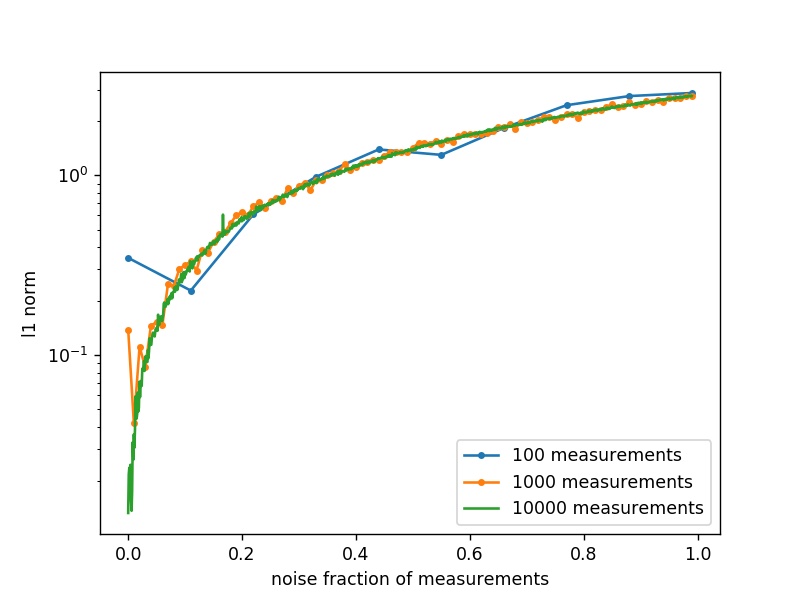

In [933]:
plt.figure()
plt.semilogy(np.linspace(0,0.99,10), hist_data[:10], '.-', label='100 measurements')
plt.semilogy(np.linspace(0,0.99,100), hist_data[10:110], '.-', label='1000 measurements')
plt.semilogy(np.linspace(0,0.99,1000), hist_data[110:1110], '-',  label='10000 measurements')
plt.ylabel('l1 norm')
plt.xlabel('noise fraction of measurements')
plt.legend()
plt.show()
plt.savefig('l1_norm estimation of decaying channel with unbiased noise')

In [909]:
repeats=50
hist_data=[]
for ensemble in [10,100,1000,10000]:
    counter = 0
    while counter < repeats:
        result = coh_opt(ensemble_size=ensemble, channel_params=decaying, in_basis=state_params, 
                  me_basis=[X,Y,Z], f=f, cons=(con1, con2, con3, con4, con5, con6), method='l1')
        print(result[0], result[1], result[2])
        counter+=1
        hist_data.append(result[0])
    if counter == repeats:
        print("{} measurements line ----".format(ensemble))

    

0.40001933946331836 (0.997494058488274+0j) [-0.   0.  -0.   0.8  1.   0.8]
0.691781828199471 (0.9881311335577537+0j) [-0.     0.003  0.028  0.894  0.638  0.539]
0.5067346715005903 (1.0012451874531414+0j) [-0.     0.1    0.004  0.912  0.9    0.988]
0.41264668930503284 (0.9986754429604265+0j) [ 0.103 -0.003  0.077  0.897  0.837  0.923]
0.5912591754700733 (0.9987036322386852+0j) [ 0.141 -0.109  0.045  0.799  0.891  0.887]
0.3997523651623479 (1.003250637943579+0j) [ 0.    -0.162  0.162  1.     0.838  0.838]
0.8441578147222344 (1.0039059588814983+0j) [-0.023 -0.179  0.4    0.725  0.821  0.6  ]
0.07161652409305265 (1.000163204422657+0j) [ 0.023 -0.043  0.201  0.899  0.895  0.799]
0.20003091800888723 (1.0000000000879243+0j) [-0.   0.   0.2  1.   0.8  0.8]
0.8783090916500389 (1.0015523164879006+0j) [0.136 0.176 0.392 0.784 0.824 0.608]
0.6059107880719274 (0.9961648757160226+0j) [-0.201  0.1    0.302  0.799  0.9    0.698]
0.3999736583151262 (0.9949747826524586+0j) [ 0.2 -0.   0.2  0.8  1.   0.8

0.08122000903002623 (0.9999944851825121+0j) [0.012 0.01  0.211 0.882 0.87  0.789]
0.06045109244038419 (1.000002376535505+0j) [0.009 0.01  0.189 0.91  0.898 0.811]
0.04994561350121928 (0.9999947774733793+0j) [0.008 0.005 0.207 0.873 0.895 0.793]
0.0992357904704451 (0.9999744785767452+0j) [-0.017 -0.009  0.189  0.921  0.868  0.811]
0.09262793246706313 (0.9999979159515089+0j) [-0.006  0.004  0.184  0.858  0.909  0.816]
0.03186395430064812 (0.999958107615325+0j) [0.018 0.001 0.198 0.892 0.901 0.802]
0.04947037765708777 (1.000043761625075+0j) [0.006 0.02  0.197 0.903 0.882 0.8  ]
0.0684574959523218 (1.000000589263424+0j) [-0.     0.002  0.215  0.884  0.869  0.785]
0.05735376430500441 (0.9999991608673977+0j) [0.007 0.011 0.18  0.905 0.893 0.808]
0.042824687601412184 (0.9999678856580774+0j) [0.019 0.011 0.198 0.903 0.894 0.798]
0.035214316698147 (1.0000034621925193+0j) [-0.003 -0.006  0.192  0.897  0.886  0.808]
0.06902009130952674 (0.9999983537277445+0j) [-0.009 -0.008  0.186  0.905  0.908  

0.017248010464759822 (0.9999978674815275+0j) [-0.004  0.001  0.198  0.9    0.893  0.802]
0.01725173418523958 (1.0000024631918378+0j) [0.002 0.005 0.199 0.889 0.892 0.801]
0.01830064010865202 (1.000000884629647+0j) [ 0.004 -0.005  0.198  0.896  0.89   0.802]
0.012885822082399242 (1.0000008554218107+0j) [-0.001  0.004  0.198  0.894  0.893  0.797]
10000 measurements line ----


<IPython.core.display.Javascript object>


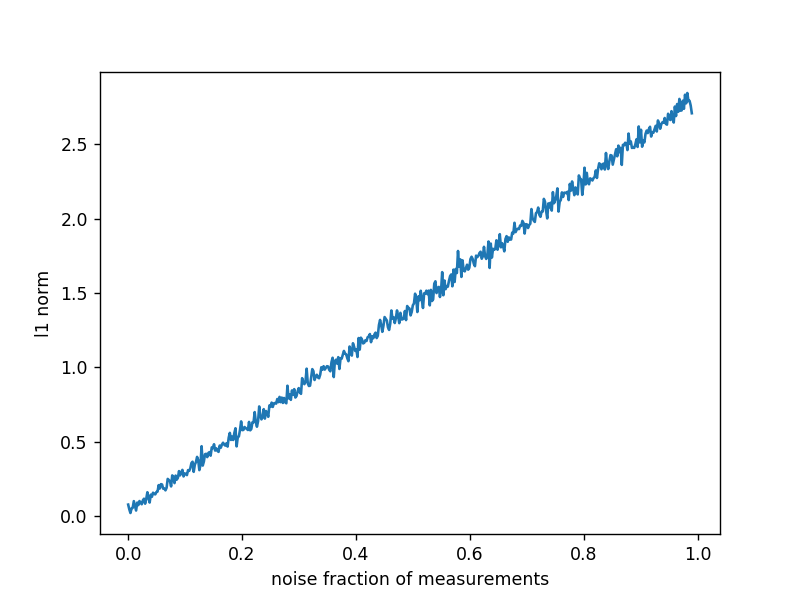

In [925]:
plt.figure()
plt.plot(np.linspace(0,0.99,10), hist_data[:10], label='100 measurements')
plt.plot(np.linspace(0,0.99,100), hist_data[10:110], label='1000 measurements')
plt.plot(np.linspace(0,0.99,1000), hist_data[110:1110], label='10000 measurements')
plt.ylabel('l1 norm')
plt.xlabel('noise fraction of measurements')
plt.show()

<IPython.core.display.Javascript object>


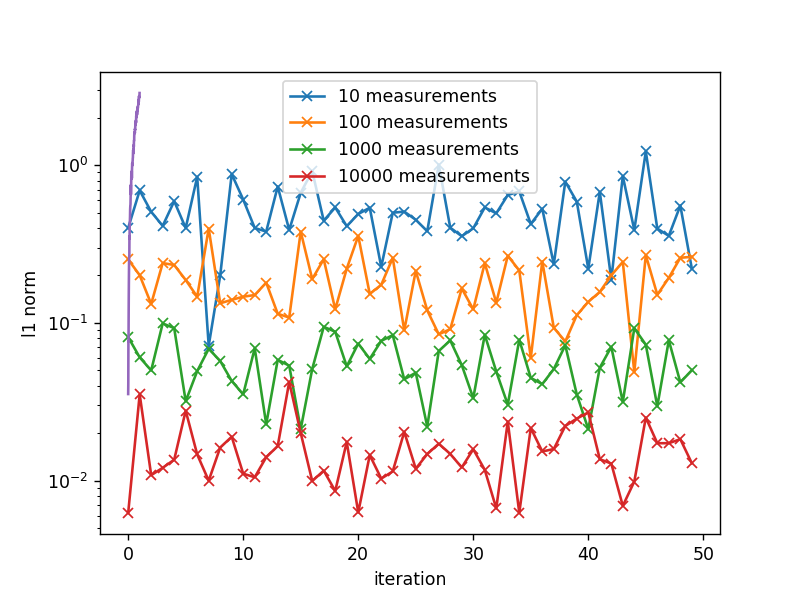

Text(0, 0.5, 'l1 norm')

In [910]:
plt.figure()
i=0
for ensemble in [10,100,1000,10000]:
    x = np.array(hist_data[(repeats)*i:(repeats)*(i+1)])
    plt.semilogy(range(repeats), x,'x-', label='{} measurements'.format(ensemble))
    i+=1
plt.show()
plt.legend()
plt.xlabel('iteration')
plt.ylabel('l1 norm')

<IPython.core.display.Javascript object>


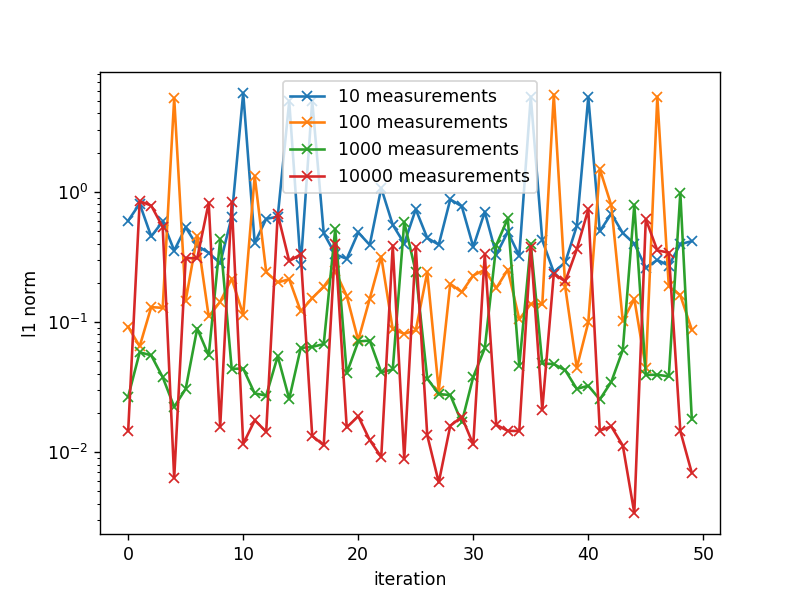

Text(0, 0.5, 'l1 norm')

In [906]:
plt.figure()
i=0
for ensemble in [10,100,1000,10000]:
    x = np.array(hist_data[(repeats)*i:(repeats)*(i+1)])
    plt.semilogy(range(repeats), x,'x-', label='{} measurements'.format(ensemble))
    i+=1
plt.show()
plt.legend()
plt.xlabel('iteration')
plt.ylabel('l1 norm')
#plt.axes.set_ylim(0, 1e-1)

<IPython.core.display.Javascript object>


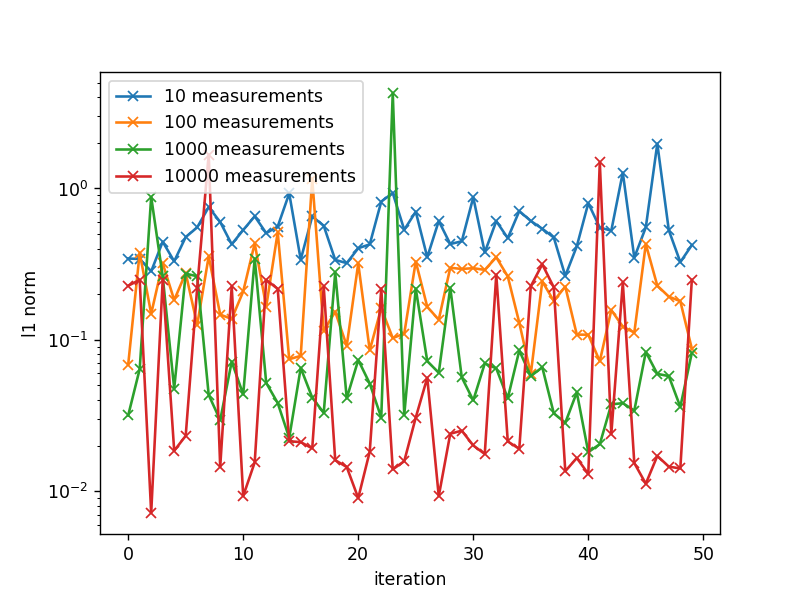

Text(0, 0.5, 'l1 norm')

In [1244]:
plt.figure()
i=0
for ensemble in [10,100,1000,10000]:
    x = np.array(hist_data[(repeats)*i:(repeats)*(i+1)])
    plt.semilogy(range(repeats), x,'x-', label='{} measurements'.format(ensemble))
    i+=1
plt.show()
plt.legend()
plt.xlabel('iteration')
plt.ylabel('l1 norm')

<IPython.core.display.Javascript object>


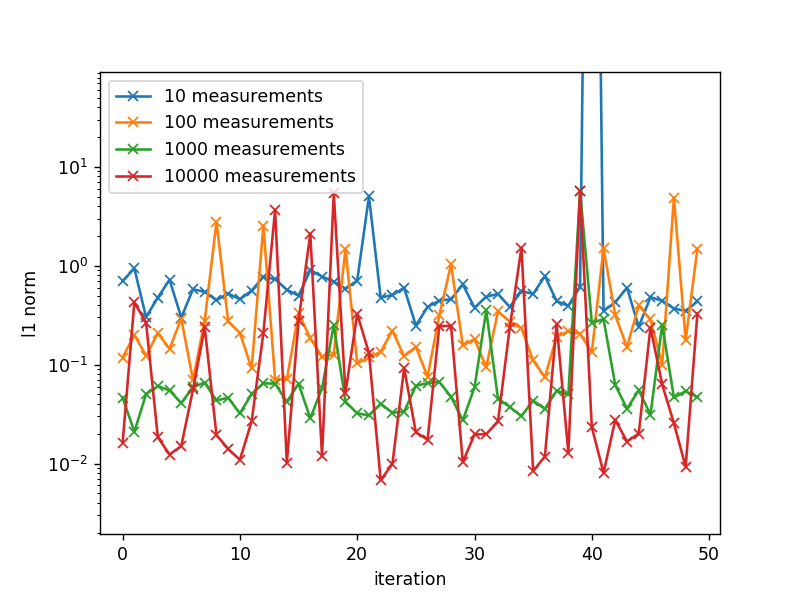

In [1241]:
plt.figure()
i=0
for ensemble in [10,100,1000,10000]:
    x = np.array(hist_data[(repeats)*i:(repeats)*(i+1)])
    plt.semilogy(range(repeats), x,'x-', label='{} measurements'.format(ensemble))
    i+=1
plt.show()
plt.legend()
plt.xlabel('iteration')
plt.ylabel('l1 norm')
plt.savefig('testing_maxlike_convergence.png')

<IPython.core.display.Javascript object>


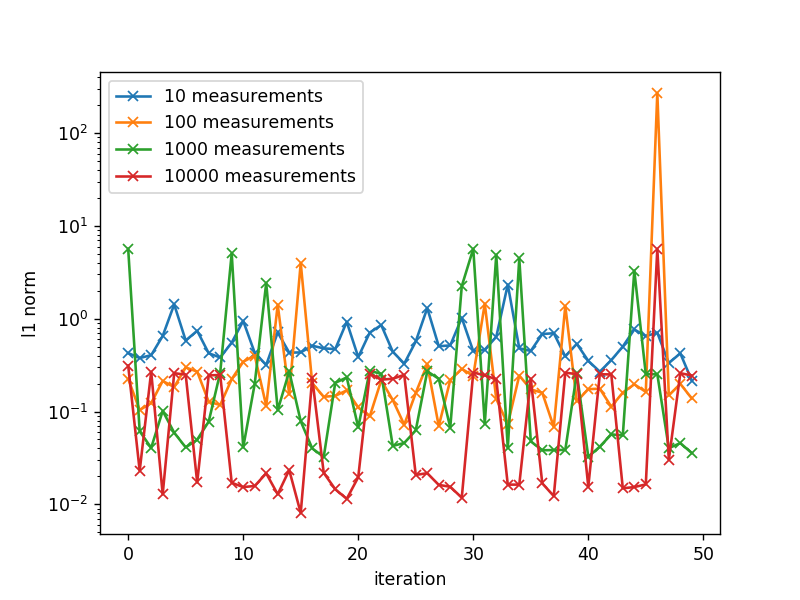

Text(0, 0.5, 'l1 norm')

In [1236]:
plt.figure()
i=0
for ensemble in [10,100,1000,10000]:
    x = np.array(hist_data[(repeats)*i:(repeats)*(i+1)])
    plt.semilogy(range(repeats), x,'x-', label='{} measurements'.format(ensemble))
    i+=1
plt.show()
plt.legend()
plt.xlabel('iteration')
plt.ylabel('l1 norm')

The maximum liklihood estimation seems to be more unstable than linear inversion methods which makes sense 
given the approximate nature of optimization and local minima problem.

## Testing out the dnorm implemented in qutip using semi-definite optimization method of Walrous et al. 2013

The diamond norm of the maps $\Phi$ and $\hat{\Phi}$ is supposed to be a stabilized norm that should be more relevant as a distance measure between quantum maps. It is dual equivalent to the completely bouned norm of its conjugate $\phi ^ \dagger$. I've spend a week reading up on convex optimization theory and it was quite handy to find the cvxpy library that does general disciplined optimization. QuTip piggy-backs on this and uses the Walrous 2013 semi-definite optimization method to define and obtain the diamond norm $\vert \vert \Phi (\rho) - \hat{\Phi}(\rho) \vert \vert \diamond$ by solving, 

$$\vert \vert \Phi (\rho) - \hat{\Phi}(\rho) \vert \vert \diamond = \max_{\text{Tr}\rho \leq 1}{\text{Tr}~(\Phi (\rho) - \hat{\Phi}(\rho)) \otimes \mathbf{I}_n}$$ 

where $\Phi (\rho): M_n \rightarrow M_k$ and the stabilizer property for the norm is defined as follows for a distance metric $d(.)$,

$$d(\mathbf{I}_n \otimes \Phi, \mathbf{I}_m \otimes \psi) \leq d(\Phi, \psi) ~~~~~ \forall m \geq 1 $$. This makes sense for a physical map that will usually act on a system interacting with the environment (i.e. any open quantum system).

Update: All norms are bounded by the l1-norm and that is the easiest to estimate for the vector that parametrizes $\hat{\Phi}(\rho)$  so maybe for computational purposes I might even ignore computation of the diamond norm as the QuTip library is soo unstable!!

Edit: Switching to proper code editor now and using version control. My code was unstable. The dnorm works well with cptp estimators. 

Update to the Update: It doesn't matter if the estimated channel is in Krauss form and is CP


In [134]:
from qutip import *

In [142]:
est_map = Qobj(ee(m[3-1]))
est_map

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.    +0.j     0.    +0.j     0.    +0.j     0.361 +0.j    ]
 [0.0055-0.0005j 0.819 +0.j     0.024 +0.j     0.0055-0.0005j]
 [0.0055+0.0005j 0.024 +0.j     0.819 +0.j     0.0055+0.0005j]
 [0.    +0.j     0.    +0.j     0.    +0.j     0.639 +0.j    ]]

In [143]:
true_map = Qobj(ee(m[4-1]))
true_map

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e-01]
 [0.00000000e+00 8.36660027e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.36660027e-01 0.00000000e+00]
 [2.77555756e-17 0.00000000e+00 0.00000000e+00 7.00000000e-01]]

In [144]:
dnorm(est_map, true_map)  # note norm is symmetric by definition

0.14882597181238857

In [146]:
np.linalg.eig(ee(m[4-1]))

(array([1.        +0.j, 0.7       +0.j, 0.83666003+0.j, 0.83666003+0.j]),
 array([[ 1.        +0.j,  0.70710678+0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j, -0.        +0.j,  1.        +0.j,
          0.        +0.j],
        [ 0.        +0.j, -0.        +0.j,  0.        +0.j,
          1.        +0.j],
        [ 0.        +0.j, -0.70710678+0.j,  0.        +0.j,
          0.        +0.j]]))

In [147]:
# channels
p=0.3
decaying = np.array([0,0,p, np.sqrt(1-p), np.sqrt(1-p), 1-p])  # two krauss operators rank_K = 2, action: mixed -> pure

x=0.2
depolarizing = (1-x)*np.array([0,0,0,1,1,1]) # rank_K=4, action: pure -> mixed (shrinks bloch sphere)

bitflip = np.array([0,0,0, 1-2*p, 1, 1-2*p])  # rank_K =2 (non zero cols essentially)

rotation = np.array([0,0,0,1,1,1])  # rank_K =1


### Testing convergence of norms for pure input states with zero noise for the 4 channels above with different ensemble sizes:

In [177]:
def norm(ensemble_size, channel):
    x = coh_opt(ensemble_size=ensemble_size, channel_params=channel, in_basis=state_params, 
                  me_basis=[X,Y,Z], f=f, cons=(con1, con2, con3, con4, con5, con6))
    
    return x[0], x[1], x[2] # diamond, l1, e_fid

In [196]:
ensembles = np.linspace(10,4000,100).astype(np.int64)  # number of measurements per eigenstate (note 6 here)
channels = [rotation, bitflip, depolarizing, decaying]
norms = np.zeros(len(ensembles)*3*len(channels)).reshape(len(channels),3,len(ensembles))
for j in range(len(channels)):
    print(channels[j])
    for i in range(len(ensembles)):
        x = norm(ensembles[i], channels[j])
        norms[j][0][i] = x[0] # dia
        norms[j][1][i] = x[1] # l1
        norms[j][2][i] = x[2] # e_fid


[0 0 0 1 1 1]


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  aux = b + copysign(sqrt_discriminant, b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:218: ComplexWarning: Casting complex values to real discards the imaginary part
  return self._symv(1, self.B, p)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  aux = b + copysign(sqrt_discriminant, b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_u

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  aux = b + copysign(sqrt_discriminant, b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_u

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  aux = b + copysign(sqrt_discriminant, b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:218: ComplexWarning: Casting complex values to real discards the imaginary part
  return self._symv(1, self.B, p)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:329: ComplexWarning: Casting complex values to real discards the imaginary part
  self.B = self._syr(1.0 / ys, y, a=self.B)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:330: ComplexWarning: Casting complex values to real discards the imaginary part
  self.B = self._syr(-1.0 / sBs, Bs, a=self.B)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:195: ComplexWarning: Casting complex values to real discards the i

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  aux = b + copysign(sqrt_discriminant, b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_u

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  aux = b + copysign(sqrt_discriminant, b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_u

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  aux = b + copysign(sqrt_discriminant, b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_u

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  aux = b + copysign(sqrt_discriminant, b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:218: ComplexWarning: Casting complex values to real discards the imaginary part
  return self._symv(1, self.B, p)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:329: ComplexWarning: Casting complex values to real discards the imaginary part
  self.B = self._syr(1.0 / ys, y, a=self.B)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:330: ComplexWarning: Casting complex values to real discards the imaginary part
  self.B = self._syr(-1.0 / sBs, Bs, a=self.B)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:212: RuntimeWarning: invalid value encountered in true_divide
  

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  aux = b + copysign(sqrt_discriminant, b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:218: ComplexWarning: Casting complex values to real discards the imaginary part
  return self._symv(1, self.B, p)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:195: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:329: ComplexWarning: Casting complex values to real discards the imaginary part
  self.B = self._syr(1.0 / ys, y, a=self.B

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  aux = b + copysign(sqrt_discriminant, b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:218: ComplexWarning: Casting complex values to real discards the imaginary part
  return self._symv(1, self.B, p)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:329: ComplexWarning: Casting complex values to real discards the imaginary part
  self.B = self._syr(1.0 / ys, y, a=self.B)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:330: ComplexWarning: Casting complex values to real discards the imaginary part
  self.B = self._syr(-1.0 / sBs, Bs, a=self.B)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:195: ComplexWarning: Casting complex values to real discards the i

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  v[P] = aux2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:476: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:128:

SolverError: Solver 'CVXOPT' failed. Try another solver, or solve with verbose=True for more information.

<IPython.core.display.Javascript object>


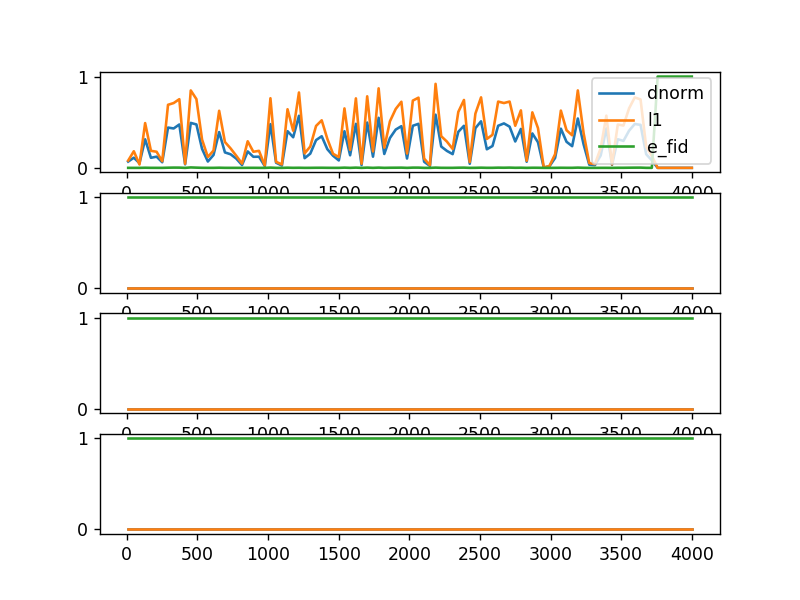

In [199]:
fig, ax = plt.subplots(4)
ax[0].plot(ensembles, norms[0][0], label='dnorm')
ax[0].plot(ensembles, norms[0][1], label='l1')
ax[0].plot(ensembles, (1-norms[0][2]), label='e_fid')
ax[0].legend()

j=1
ax[j].plot(ensembles, norms[j][0], label='dnorm')
ax[j].plot(ensembles, norms[j][1], label='l1')
ax[j].plot(ensembles, (1-norms[j][2]), label='e_fid')

j=2
ax[j].plot(ensembles, norms[j][0], label='dnorm')
ax[j].plot(ensembles, norms[j][1], label='l1')
ax[j].plot(ensembles, (1-norms[j][2]), label='e_fid')

j=3
ax[j].plot(ensembles, norms[j][0], label='dnorm')
ax[j].plot(ensembles, norms[j][1], label='l1')
ax[j].plot(ensembles, (1-norms[j][2]), label='e_fid')


In [181]:
1-norms[0][2]

array([-3.44074116e-04,  4.87680785e-04, -3.59475116e-10,  6.93662994e-07,
        3.66117615e-05,  1.64094614e-03,  1.41504695e-04,  2.77053525e-05,
        9.75952491e-04, -1.39721959e-06])

In [109]:

def av(iterations, params, noise, bias):
    sum = 0
    i = 0
    while i < iterations:
        sum += coh_opt(ensemble_size=1000, noise_fraction=noise, channel_params=cpars, 

            in_basis=params, 

            me_basis=[X,Y,Z], f=f, cons=(con1, con2, con3, con4, con5, con6), method='l1', bias=bias)[0]
        i+=1

    return sum / i

### randomization of bloch-search space doesn't seem to work very well in biased or unbiased noise compared with vanilla init_state prep

In [502]:
it = 50
repeat = 10
for i in range(repeat):
    size = 6
    randi = np.array([(np.pi*np.random.random(size=size)), np.random.random(size=size)*np.pi*2]).reshape(size,2)
    mc_params = [eta(randi[i][0], randi[i][1]) for i in range(len(randi))]
    print([av(it, mc_params, 0.4, 0), av(it, mc_params, 0.4, -1), av(it, mc_params, 0.4, 1), av(it, mc_params, 0.4, -2)]) # x, y, z, unbiased noise

[0.38262597966739276, 0.4064989542604963, 0.6112638096407266, 1.095362355109985]
[0.37197183175535775, 0.38199828869146296, 0.5796430581261338, 1.0928053033411038]
[0.3637437331454447, 0.40930610368927967, 0.6956233659451114, 1.0955823186175204]
[0.4002388370995809, 0.3951263205659471, 0.6506238605864805, 1.1071444069947352]
[0.4259260096189162, 0.39968648960390324, 0.783428983477753, 1.1289249911727042]
[0.39489174569608443, 0.42728385208195, 0.7034692818171178, 1.1014098576925342]
[0.42033800622165507, 0.38606538843024557, 0.65642979593373, 1.1015392570274871]
[0.3958630522141863, 0.389248981591821, 0.6654550744270225, 1.094322927487648]
[0.3884009505663035, 0.4206411633827337, 0.617188810868486, 1.0957142322445819]
[0.42892581430723903, 0.3675596912093912, 0.7437401505694057, 1.105395375957645]


In [216]:
it = 50
p2 = [np.array([1, 0, 0]),
 np.array([-1,  0,  0]),
 np.array([0, 1, 0]),
 np.array([ 0, -1,  0]),
 np.array([ 0,  0, -1]),
 np.array([0, 0, 1])]
[av(it, p2, 0.4, 0), av(it, p2, 0.4, -1), av(it, p2, 0.4, 1), av(it, p2, 0.4, -2)] # x, y, z, unbiased noise for sep init stats

[0.37967410289588366,
 0.382236333193527,
 0.5331122033789224,
 1.1005619035472916]

In [217]:
it = 50
p2 = [np.array([1, 0, 0]),
 np.array([-1,  0,  0]),
 np.array([0, 1, 0]),
 np.array([ 0, -1,  0]),
 np.array([ 0,  -1, 0]),
 np.array([0, 1, 0])]
[av(it, p2, 0.4, 0), av(it, p2, 0.4, -1), av(it, p2, 0.4, 1), av(it, p2, 0.4, -2)] # x, y, z, unbiased noise for sep init stats

[0.6082865934270681, 0.6167410753608393, 0.2051258519161748, 1.180232016311244]

In [207]:
double_state_params = [i for i in state_params] + [i for i in state_params]
[i for i in state_params]

[array([1, 0, 0]),
 array([-1,  0,  0]),
 array([0, 1, 0]),
 array([ 0, -1,  0]),
 array([ 0,  0, -1]),
 array([0, 0, 1])]

### try grid searching the bloch-space instead:

In [541]:
size = 12
#randi = np.array([(np.pi*np.linspace(0,1,size)), np.linspace(0,1,size)*np.pi*2]).reshape(size,2)
randi = np.stack(((np.pi*np.linspace(0,1,size)), np.linspace(0,1,size)*np.pi*2), axis=1)
mc_params = [eta(randi[i][0], randi[i][1]) for i in range(len(randi))]
mc_params

[array([0., 0., 1.]),
 array([0.23700851, 0.15231612, 0.95949297]),
 array([0.22459031, 0.49178419, 0.84125353]),
 array([-0.10755438,  0.74805713,  0.65486073]),
 array([-0.59568228,  0.68745399,  0.41541501]),
 array([-0.94972672,  0.27886493,  0.14231484]),
 array([-0.94972672, -0.27886493, -0.14231484]),
 array([-0.59568228, -0.68745399, -0.41541501]),
 array([-0.10755438, -0.74805713, -0.65486073]),
 array([ 0.22459031, -0.49178419, -0.84125353]),
 array([ 0.23700851, -0.15231612, -0.95949297]),
 array([ 1.22464680e-16, -2.99951957e-32, -1.00000000e+00])]

In [542]:
print([av(it, mc_params, 0.4, 0), av(it, mc_params, 0.4, -1), av(it, mc_params, 0.4, 1), av(it, mc_params, 0.4, -2)]) # x, y, z, unbiased noise

[0.36950096030390284, 0.3711538920893296, 0.6441677821526035, 1.0899788466012352]


In [485]:
mc_params

[array([-0.18636596,  0.5616635 , -0.80610287]),
 array([-0.35759103,  0.65859846, -0.66210024]),
 array([-0.27540043,  0.88924391, -0.36523947]),
 array([-0.4376259 ,  0.33782258,  0.83328235]),
 array([ 0.50569642,  0.85370876, -0.12430802]),
 array([-0.59122472,  0.80498345, -0.04954774]),
 array([-0.48162788, -0.45554197, -0.74867623]),
 array([0.1066919 , 0.88854245, 0.44621649]),
 array([-0.60128593,  0.69917687,  0.38679056]),
 array([ 0.35412552,  0.49179445, -0.79544537]),
 array([-0.36038262,  0.77697861,  0.51616723]),
 array([ 0.855292  , -0.30744566,  0.41707644])]

In [424]:
eta(np.pi, 2*np.pi)

array([ 1.22464680e-16, -2.99951957e-32, -1.00000000e+00])

### detour/appendix: plotting a bloch vector in phase space (theta, phi) to study behavior later

In [174]:
norms[0][2]

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25])

<IPython.core.display.Javascript object>


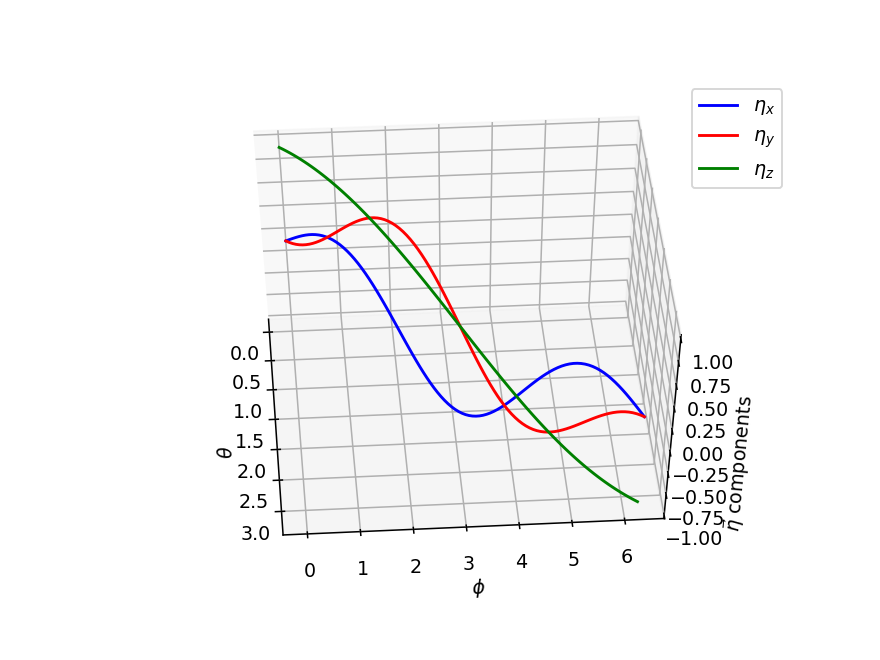

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits import mplot3d
theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2*np.pi, 100)
x, y, z = np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)


fig = plt.figure()
ax = plt.axes(projection="3d")

z_line = np.linspace(0, 15, 1000)
x_line = np.cos(z_line)
y_line = np.sin(z_line)
ax.plot3D(theta, phi, x, 'b', label=r'$\eta_x$')
ax.plot3D(theta, phi, y, 'r', label=r'$\eta_y$')
ax.plot3D(theta, phi, z, 'g', label=r'$\eta_z$')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
ax.set_zlabel(r'$\vec{\eta}$ components')

plt.legend()

plt.show()

<IPython.core.display.Javascript object>


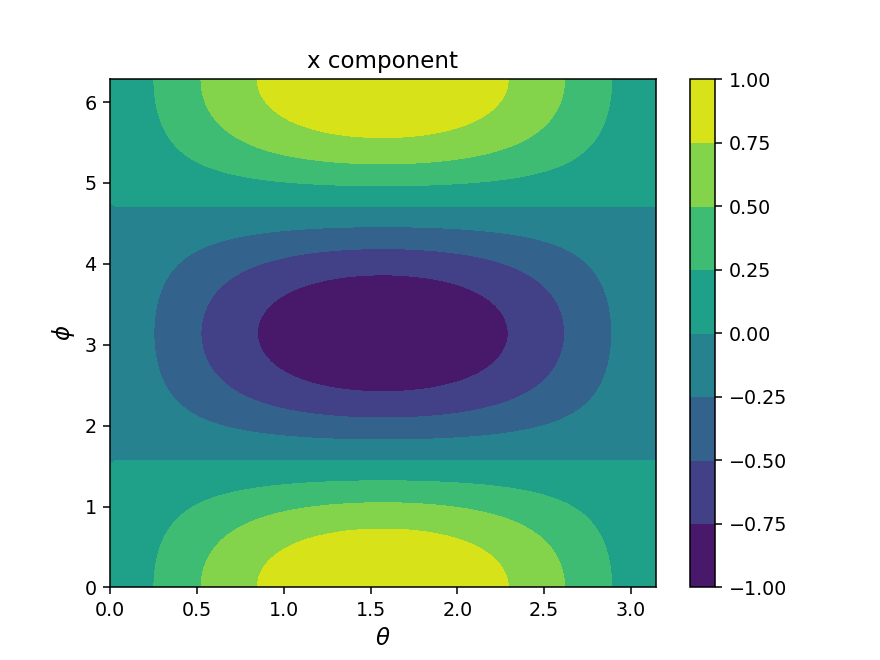

<IPython.core.display.Javascript object>


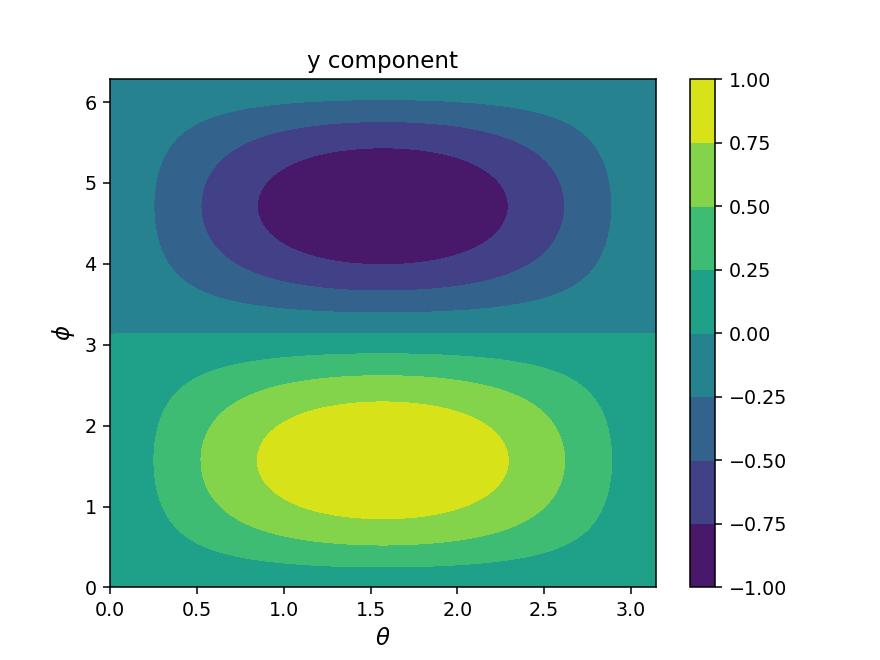

<IPython.core.display.Javascript object>


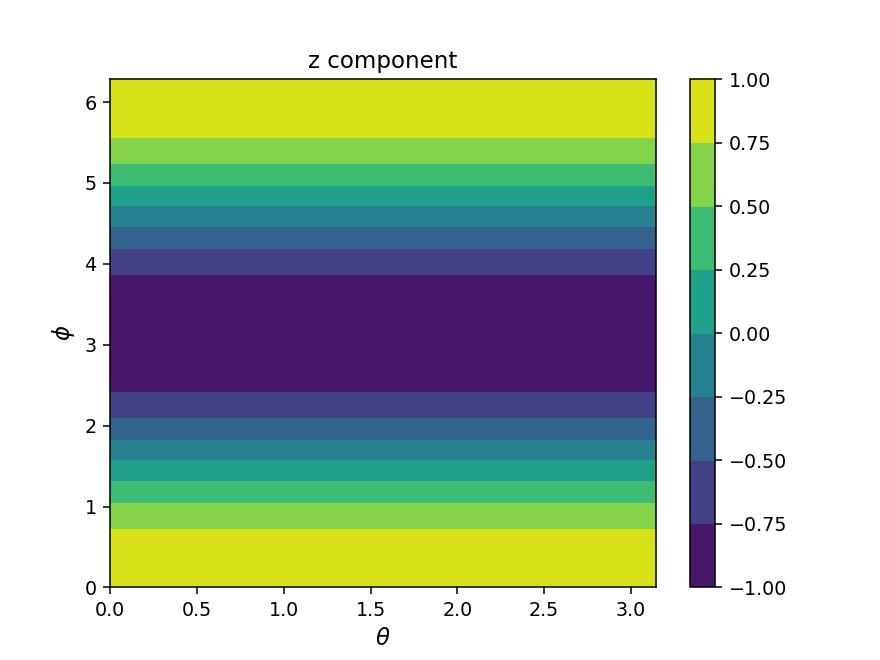

Text(0.5, 1.0, 'z component')

In [6]:

a, b = np.meshgrid(theta, phi)
x, y, z = np.sin(a)*np.cos(b), np.sin(a)*np.sin(b), np.cos(b)
plt.figure()
plt.contourf(a,b,x)
plt.xlabel(r"$\theta$", size=12)
plt.ylabel(r"$\phi$", size=12)
plt.colorbar()
plt.title('x component')


plt.figure()
plt.contourf(a,b,y)
plt.xlabel(r"$\theta$", size=12)
plt.ylabel(r"$\phi$", size=12)
plt.colorbar()
plt.title('y component')

plt.figure()
plt.contourf(a,b,z)
plt.xlabel(r"$\theta$", size=12)
plt.ylabel(r"$\phi$", size=12)
plt.colorbar()
plt.title('z component')

In [7]:
y

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.01230991e-03,  4.02259358e-03, ...,
         4.02259358e-03,  2.01230991e-03,  7.76719002e-18],
       [ 0.00000000e+00,  4.01651695e-03,  8.02898960e-03, ...,
         8.02898960e-03,  4.01651695e-03,  1.55031043e-17],
       ...,
       [-0.00000000e+00, -4.01651695e-03, -8.02898960e-03, ...,
        -8.02898960e-03, -4.01651695e-03, -1.55031043e-17],
       [-0.00000000e+00, -2.01230991e-03, -4.02259358e-03, ...,
        -4.02259358e-03, -2.01230991e-03, -7.76719002e-18],
       [-0.00000000e+00, -7.77110244e-18, -1.55343800e-17, ...,
        -1.55343800e-17, -7.77110244e-18, -2.99951957e-32]])

### Try optimization with penalties by modifying the objective function: 
 (doesn't seem to make much difference)

In [ ]:
def f_pen(x, mo, states):
    clicks = len(mo)
    init_states = ensembler([int(clicks / len(states)) for _ in range(len(states))], states)
    emap = sensembler(clicks, ee(x))
    transformed_vecs = np.matmul(emap, init_states)
    trhos = vrho(transformed_vecs[:,1:])
    likelihood = np.trace(np.matmul(mo, trhos), axis1=1, axis2=2)   # minimizing rather than maximizing here, first minus comes as prob is negative
    
    loglike = -1*-1*np.where(likelihood != 0, np.log(likelihood), 0) # might need to take care of infinities due to log zero
    
    penalty_1 = -1e8*(+abs(1+x[5])-abs(x[3]+x[4]))
    penalty_2 = -1e8*(+abs(1-x[5])-abs(x[3]-x[4]))
    
    
    return np.real(np.sum(loglike)) + penalty_1 + penalty_2


print(f_pen([0, 0, 0, 0.5, 0.5, 1], mo, states))
unconstrained_opt = sp.optimize.minimize(f_pen, np.zeros(6),args=(mo, states), method='Nelder-Mead', options={'disp': True,'maxiter': 200})

entanglement_fidelity(unconstrained_opt.x, [0,0,0,0.5,0.5,1])


unconstrained_opt.x

ee(unconstrained_opt.x)